Last updated: 30 Sep 2024

This is a copy of what I'm trying to do with optimized memory v0, but I want to use the same distances for mantle grids as in Mantle layering.ipynb. I think there is no reason for the resulting plots to be different if we split the layers into sublayers in this way, and sum up the integrals at the end. After all, the underlying grid points are the same and the same conditions are imposed to select them.



In [115]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import gc
import psutil
import os

# Function to get current process memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    # Convert bytes to megabytes
    mem_usage_mb = mem_info.rss / (1024 ** 2)
    print(f"Current memory usage: {get_memory_usage():.2f} MB")
    return mem_usage_mb
print("imports successful")
print("imports successful")

grid_count_crust = 640 # would need 637.1 for 20 km spacing
#1275 for 5 km spacing
coordinates = np.linspace(-6371, 6371, grid_count_crust)
grid_1d_size_crust = coordinates[1]-coordinates[0]

# Generate the grid coordinates using meshgrid
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

print(len(x_coordinates), len(y_coordinates), len(z_coordinates))

# Calculate the distance of each point from the origin using vectorized operations
distances_squared_crust = x_coordinates**2 + y_coordinates**2 + z_coordinates**2

print(f'size of dist squared : {np.size(distances_squared_crust)}')
print(f'len of dist squared : {len(distances_squared_crust)}')
print(f'shape of dist squared : {np.shape(distances_squared_crust)}')

# Find indices where distance is less than or equal to the radius squared
crust_indices = np.logical_and(6350**2 < distances_squared_crust, distances_squared_crust <= 6371**2)

print(len(distances_squared_crust))
print(len(distances_squared_crust[crust_indices]))

# Extract valid coordinates using boolean indexing
crust_grid = np.stack((x_coordinates[crust_indices], y_coordinates[crust_indices], z_coordinates[crust_indices]), axis=-1)


print("crust grid created successfully; deleting useless stuff")
print(f"Current memory usage: {get_memory_usage():.2f} MB")
del x_coordinates, y_coordinates, z_coordinates
del coordinates
#del distances_squared_crust
#del crust_indices
print('deleted')
print(f"Current memory usage: {get_memory_usage():.2f} MB")
print('use gc collect')
gc.collect()
print(f"Current memory usage: {get_memory_usage():.2f} MB")

imports successful
imports successful
640 640 640
size of dist squared : 262144000
len of dist squared : 640
shape of dist squared : (640, 640, 640)
640
1344768
crust grid created successfully; deleting useless stuff
Current memory usage: 12759.36 MB
deleted
Current memory usage: 6759.36 MB
use gc collect
Current memory usage: 6759.36 MB


The size of distances_squared is determined by the size of the 3D grid generated by np.meshgrid, which in turn is based on the length of the coordinates array.

Here’s how it works:

    coordinates is a 1D array of length grid_count_crust, which is 640 in this case.
    

    np.meshgrid(coordinates, coordinates, coordinates) creates three 3D grids: x_coordinates, y_coordinates, and z_coordinates. Each of these grids has a shape of (640, 640, 640) because the grid spans 640 points along each of the three dimensions (x, y, and z).
    

    distances_squared is calculated by squaring each element of x_coordinates, y_coordinates, and z_coordinates and adding them together. Since each of the coordinate grids has a shape of (640, 640, 640), the resulting distances_squared array will also have the same shape.

Thus, the size (or shape) of distances_squared is (640, 640, 640), which is a 3D array containing the squared distances of all the points in the grid from the origin.

So the x, y and z coordinates contain the whole grid, and now crust_grid is an array that contains triplets (x, y, z) for all the points in the crust. Great! Now we want to select the indices for the other layers. My hope is that if we make them thin enough, everything will work. 

I am doing this manually for now, just to see if it works.

In [116]:
grid_count_mantle = 600 # would need 637.1 for 20 km spacing
#320 for 40 km spacing
#285 for 45 km spacing
#215 for 60km spacing
#160 for 80km spacing
coordinates = np.linspace(-6371, 6371, grid_count_mantle)
grid_1d_size_mantle = coordinates[1]-coordinates[0]

# Generate the grid coordinates using meshgrid
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

# Calculate the distance of each point from the origin using vectorized operations
distances_squared = x_coordinates**2 + y_coordinates**2 + z_coordinates**2

In [117]:
# Calculate average distance 

In [118]:
CLM_indices = np.logical_and(6196**2 < distances_squared, distances_squared <= 6350**2)
CLM_grid = np.stack((x_coordinates[CLM_indices], y_coordinates[CLM_indices], z_coordinates[CLM_indices]), axis=-1)

#good_CLM_distances = distances_squared[CLM_indices]**(0.5)

In [119]:
#DM is between 4202 amd 6196
#a's are just limits of the mini layers to constrain the radius

a0 = 4202
a1 = 4300
a2 = 4400
a3 = 4500
a4 = 4600
a5 = 4700
a6 = 4800
a7 = 4900
a8 = 5000
a9 = 5100
a10 = 5200
a11 = 5300
a12 = 5400
a13 = 5500
a14 = 5600
a15 = 5700
a16 = 5800
a17 = 5900
a18 = 6100
a19 = 6196

a_values = np.array([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19])

# Initialize an empty object array to hold the DM grids
DM_grids = np.empty(len(a_values) - 1, dtype=object)
DM_indices_array = np.empty(len(a_values) - 1, dtype=object)

#good_DM_distances_array = np.empty(len(a_values) - 1, dtype=object)

for i in range(len(a_values) - 1):
    print(i)
    DM_indices = np.logical_and(a_values[i]**2 < distances_squared, distances_squared <= a_values[i + 1]**2)
    try:
        # Attempt to create the DM_grid
        DM_grid = np.stack((x_coordinates[DM_indices], y_coordinates[DM_indices], z_coordinates[DM_indices]), axis=-1)
        
        # Store the DM_grid and DM_indices in the object arrays
        DM_grids[i] = DM_grid
        DM_indices_array[i] = DM_indices
        #good_DM_distances_array[i] = distances_squared[DM_indices]**(0.5)
        
        print(f"DM{i+1} grid done, limits: {a_values[i]} , {a_values[i + 1]}")
    
    except MemoryError:
        # Catch memory errors and print a message
        print(f"MemoryError encountered while creating DM{i+1} grid with limits: {a_values[i]} , {a_values[i + 1]}")




0
DM1 grid done, limits: 4202 , 4300
1
DM2 grid done, limits: 4300 , 4400
2
DM3 grid done, limits: 4400 , 4500
3
DM4 grid done, limits: 4500 , 4600
4
DM5 grid done, limits: 4600 , 4700
5
DM6 grid done, limits: 4700 , 4800
6
DM7 grid done, limits: 4800 , 4900
7
DM8 grid done, limits: 4900 , 5000
8
DM9 grid done, limits: 5000 , 5100
9
DM10 grid done, limits: 5100 , 5200
10
DM11 grid done, limits: 5200 , 5300
11
DM12 grid done, limits: 5300 , 5400
12
DM13 grid done, limits: 5400 , 5500
13
DM14 grid done, limits: 5500 , 5600
14
DM15 grid done, limits: 5600 , 5700
15
DM16 grid done, limits: 5700 , 5800
16
DM17 grid done, limits: 5800 , 5900
17
DM18 grid done, limits: 5900 , 6100
18
DM19 grid done, limits: 6100 , 6196


This worked quite well, let's see if we can create the ones for EM as well. It should be fine, given that DM was the chonkiest one

In [ ]:
#EM is between 3480 amd 4202

b0 = 3480
b1 = 3600
b2 = 3700
b3 = 3800
b4 = 3900
b5 = 4000
b6 = 4100
b7 = 4202


b_values = np.array([b0, b1, b2, b3, b4, b5, b6, b7])

# Initialize an empty object array to hold the DM grids
EM_grids = np.empty(len(b_values) - 1, dtype=object)
EM_indices_array = np.empty(len(b_values) - 1, dtype=object)
#good_EM_distances_array = np.empty(len(b_values) - 1, dtype=object)

for i in range(len(b_values) - 1):
    print(i)
    EM_indices = np.logical_and(b_values[i]**2 < distances_squared, distances_squared <= b_values[i + 1]**2)
    try:
        # Attempt to create the DM_grid
        EM_grid = np.stack((x_coordinates[EM_indices], y_coordinates[EM_indices], z_coordinates[EM_indices]), axis=-1)
        
        # Store the DM_grid and DM_indices in the object arrays
        EM_grids[i] = EM_grid
        EM_indices_array[i] = EM_indices
        #good_EM_distances_array[i] = distances_squared[EM_indices]**(0.5)
        
        print(f"EM{i+1} grid done, limits: {b_values[i]} , {b_values[i + 1]}")
    
    except MemoryError:
        # Catch memory errors and print a message
        print(f"MemoryError encountered while creating EM{i+1} grid with limits: {b_values[i]} , {b_values[i + 1]}")


0


Ok, we have all the grids! I don't know why this takes up less memory, i even have less memory now because I repartitioned my laptop to get windows as well so I have even less memory available. I will ask chatgpt about this

I didn't make it very clear to me why the difference in memory handling is so significant, I feel like chunking it like this or making one big array should occupy rouglhy the same memory, but anyway. I want to print the sizes of the arrays of arrays 

In [111]:
print("mantle grid created successfully; deleting useless stuff")
print(f"Current memory usage: {get_memory_usage():.2f} MB")
del x_coordinates, y_coordinates, z_coordinates
del coordinates
del distances_squared
del CLM_indices
del DM_indices_array
del EM_indices_array
print('deleted')
print(f"Current memory usage: {get_memory_usage():.2f} MB")
print('use gc collect')
gc.collect()
print(f"Current memory usage: {get_memory_usage():.2f} MB")

mantle grid created successfully; deleting useless stuff
Current memory usage: 15586.77 MB
deleted
Current memory usage: 6542.69 MB
use gc collect
Current memory usage: 6542.69 MB


The following few cells have been copied exactly from the Mantle layering.ipynb script:


In [112]:
print("setting densities and abundances")
# Define the parameter sets

# Placeholder definitions for IDE recognition
A_Th_c = A_U_c = A_Th_CLM = A_U_CLM = A_Th_DM1 = A_U_DM1 = A_Th_DM2 = A_U_DM2 = A_Th_EM = A_U_EM = 0

low_abundances = {
    "A_Th_c": 5 * (10**(-6)),
    "A_U_c": 1 * (10**(-6)),
    "A_Th_CLM": 53 * (10**(-9)),
    "A_U_CLM": 13 * (10**(-9)),
    "A_Th_DM": 17.52 * (10**(-9)),
    "A_U_DM": 6.4 * (10**(-9)),
    "A_Th_EM": 90 * (10**(-9)),
    "A_U_EM": 15 * (10**(-9))
}

mid_abundances = {
    "A_Th_c": 5 * (10**(-6)),
    "A_U_c": 1 * (10**(-6)),
    "A_Th_CLM": 147 * (10**(-9)),
    "A_U_CLM": 33 * (10**(-9)),
    "A_Th_DM": 21.9 * (10**(-9)),
    "A_U_DM": 8 * (10**(-9)),
    "A_Th_EM": 147 * (10**(-9)),
    "A_U_EM": 33 * (10**(-9))
}

high_abundances = {
    "A_Th_c": 5 * (10**(-6)),
    "A_U_c": 1 * (10**(-6)),
    "A_Th_CLM": 427 * (10**(-9)),
    "A_U_CLM": 83 * (10**(-9)),
    "A_Th_DM": 26.28 * (10**(-9)),
    "A_U_DM": 9.6 * (10**(-9)),
    "A_Th_EM": 221 * (10**(-9)),
    "A_U_EM": 57 * (10**(-9))
}

# Function to select the parameter set
def select_abundances(abundance_set):
    globals().update(abundance_set)

# Choose the desired parameter set by name
abundances = mid_abundances  # Change to mid_abundances or high_abundances as needed
select_abundances(abundances)



rho_c = 2.7
rho_CLM = 3.3 #g/cm^3 probably
rho_DM = 3.3
rho_EM = 3.3
print("densities and abundances set successfully")

#we have pretty much everything to compute things separately!
# compute for crust
#set position of SNO+

print("setting detector position")

SNO_r = np.array([0, 0, 6369])
# function to calculate relative distance to SNO+ from points in earth grid

setting densities and abundances
densities and abundances set successfully
setting detector position


In [113]:
def calc_relative_dist(points_array):
    # Calculate the Euclidean distance using vectorized operations
    relative_distances = np.linalg.norm(points_array - SNO_r, axis=1)
    
    print("   ")
    print("Computed relative distances from Earth grid points to SNO+")
    print("   ")
    
    return relative_distances


#define Delta function for an array of points and energies
#inputs: appropriate deltam _ij^2, energy array [MeV], points array
#relative distance calculated in km, hence Delta scaled up by a factor of 1000 to account for m-km conversion

def Delta_ij(energy_array, points_array, delta_m_ij_squared):
    # Calculate relative distances
    relative_distance_array = calc_relative_dist(points_array)

    # Reshape energy_array to perform element-wise division
    energy_array_reshaped = energy_array.reshape(-1, 1)

    # Calculate Delta using vectorized operations
    Delta = (1.27 * delta_m_ij_squared * relative_distance_array * 1000) / (energy_array_reshaped)
    
    print('computed; deleting useless stuff')
    print(f"Current memory usage: {get_memory_usage():.2f} MB")
    del relative_distance_array
    del energy_array_reshaped
    print('deleted')
    print(f"Current memory usage: {get_memory_usage():.2f} MB")

    return Delta

In [114]:
crust_relative_distances = calc_relative_dist(crust_grid)
CLM_relative_distances = calc_relative_dist(CLM_grid)

DM_relative_distances_array = np.empty(len(a_values) - 1, dtype = object)
for i in range(len(a_values) - 1):
    DM_relative_distances_array[i] = calc_relative_dist(DM_grids[i])

EM_relative_distances_array = np.empty(len(b_values) - 1, dtype=object)
for i in range(len(b_values) - 1):
    EM_relative_distances_array[i] = calc_relative_dist(EM_grids[i])


EM_relative_distances = np.concatenate(EM_relative_distances_array)
DM_relative_distances = np.concatenate(DM_relative_distances_array)

mantle_relative_distances = np.concatenate ((CLM_relative_distances, DM_relative_distances, EM_relative_distances))

crust_avg_dist  = np.mean(crust_relative_distances)
mantle_avg_dist = np.mean(mantle_relative_distances)

print(f'Crust average distance : {crust_avg_dist}')
print(f'Mantle average distance (grid 1d size mantle : {grid_1d_size_mantle}) : {mantle_avg_dist}')


# To get the overall average, need to weight by volume element

grid_volume_el_crust = grid_1d_size_crust**3
grid_volume_el_mantle = grid_1d_size_mantle**3

average_distance = (grid_volume_el_mantle * np.sum(mantle_relative_distances) + grid_volume_el_crust * np.sum(crust_relative_distances)) / (grid_volume_el_mantle * len(mantle_relative_distances) + grid_volume_el_crust * len(crust_relative_distances))

print(f'Average distance (grid 1d size mantle : {grid_1d_size_mantle}) : {average_distance}')


   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+

In [9]:
def P_ee_full_optimized(energy_array, points_array, theta_12, theta_13, delta_m_21_squared):
    
    #P_ee = np.empty((len(energy_array), len(points_array))) # np.empty more efficient
    #than np.zeros or whatever
    #might not need this at all though
    relative_distance_array = calc_relative_dist(points_array)
    
    Delta_31 = Delta_ij(energy_array, points_array, delta_m_31_squared)
    print("Delta_31 computed successfully")
    Delta_12 = Delta_ij(energy_array, points_array, delta_m_21_squared)
    print("Delta_12 computed successfully")

    A = (np.cos(theta_13))**4 * (np.sin(2 * theta_12))**2
    B = np.sin(2 * theta_13)**2

    sin_squared_Delta_31 = np.sin(Delta_31) ** 2
    sin_squared_Delta_12 = np.sin(Delta_12) ** 2
    
    print("values computed successfully")

    P_ee = 1 - (A * sin_squared_Delta_12 + B * sin_squared_Delta_31)
    print("P_ee computed successfully")
    
    return P_ee

In [10]:
#set standard oscillation parameters
print("setting standard oscillation parameters")

theta_12 = 0.5903 #rad
theta_23 = 0.8430 #rad
theta_13 = 0.1503 #rad

delta_m_21_squared = 7.39 * 10**(-5) #eV^2
delta_m_32_squared = 2.449 * 10**(-3) #eV^2
delta_m_31_squared = delta_m_32_squared
print("defining energy array")
energy_array = np.linspace(1.81, 3.31, 100)

setting standard oscillation parameters
defining energy array


In [11]:
## optimized definition of integral, optimized P_ee
def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    print("Relative distance array computed successfully")
    P_ee_array = P_ee_full_optimized(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)
    print("P_ee_array computed successfully")

    # Compute sum_Th
    sum_Th = np.sum(P_ee_array * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    
    print("sum_Th computed successfully")
    
    # Compute sum_U
    sum_U = np.sum(P_ee_array * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    print("sum_U computed successfully")
    
    print('computed; deleting useless stuff')
    print(f"Current memory usage: {get_memory_usage():.2f} MB")
    del P_ee_array
    del relative_distance_array
    print('deleted')
    print(f"Current memory usage: {get_memory_usage():.2f} MB")

    return sum_Th, sum_U

We have defined everything that needed defining, now we got to the part where we actually have to compute integrals; the crust and CLM parts will be the same:

In [12]:
print("computing integral values for standard oscillation paramaters (crust contribution only)")    
Th_integral_values_c, U_integral_values_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12, delta_m_21_squared, A_Th_c, A_U_c, rho_c)
print("done! moving on")

computing integral values for standard oscillation paramaters (crust contribution only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2026.75 MB
deleted
Current memory usage: 2026.75 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 3053.17 MB
deleted
Current memory usage: 3053.17 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1955.86 MB
deleted
Current memory usage: 929.88 MB
done! moving on


The Mantle layering script is kind of a mess, especially when calculating things with constant P_ee, but it's fine ... I will have to rewrite this whole repo at some point and organize things nicely, but that day is not today. For now, I just want to see if splitting the layers into more sublayers makes a difference in the final plots

making plots


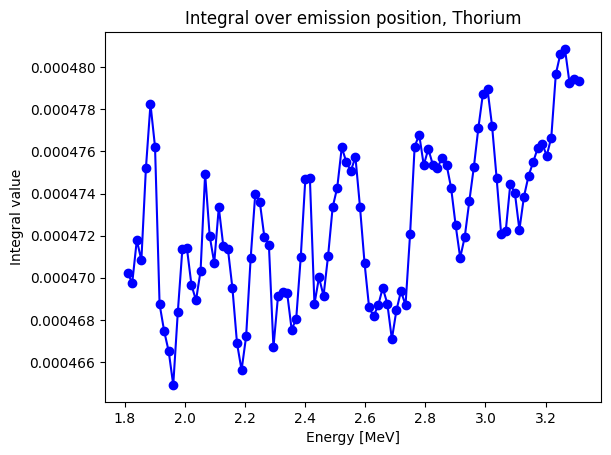

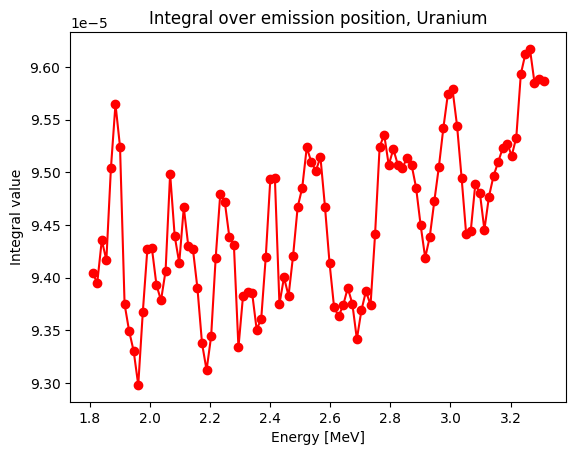

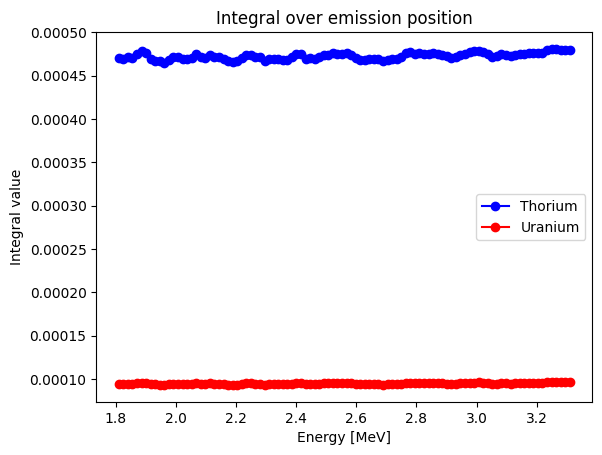

In [13]:
#make plots
print("making plots")
#Thorium
plt.plot(energy_array, Th_integral_values_c, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.savefig('Integral over emission position, Thorium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_c, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
#plt.savefig('Integral over emission position, Uranium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values_c, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values_c, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
#plt.savefig('Integral over emission position, standard oscillation parameters.pdf', format='pdf')
plt.show()

In [14]:
def integral_over_positions_Th_U_constant_P_ee(points_array, energy_array, grid_1d_size, A_Th, A_U, rho):
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_mid = 0.521
    #P_ee_mid = 0.55
    P_ee_stdev = 0.072
    P_ee_low = P_ee_mid - P_ee_stdev
    P_ee_high = P_ee_mid + P_ee_stdev
    P_ee_array_mid = np.full((len(energy_array), len(points_array)), P_ee_mid)
    P_ee_array_low = np.full((len(energy_array), len(points_array)), P_ee_low)
    P_ee_array_high = np.full((len(energy_array), len(points_array)), P_ee_high)
    
    
    # Compute sum_Th
    sum_mid_Th = np.sum(P_ee_array_mid * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_low_Th = np.sum(P_ee_array_low * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_high_Th = np.sum(P_ee_array_high * ((A_Th * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    
    # Compute sum_U
    sum_mid_U = np.sum(P_ee_array_mid * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_low_U = np.sum(P_ee_array_low * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)
    sum_high_U = np.sum(P_ee_array_high * ((A_U * rho) / (4 * np.pi * (relative_distance_array**2)))[np.newaxis, :] * dV, axis=1)

    return sum_mid_Th, sum_mid_U, sum_low_Th, sum_low_U, sum_high_Th, sum_high_U

In [15]:
print("computing integral values for standard P_ee (crust contribution only")
Th_integral_values_constant_P_ee_mid_c, U_integral_values_constant_P_ee_mid_c, Th_integral_values_constant_P_ee_low_c, U_integral_values_constant_P_ee_low_c, Th_integral_values_constant_P_ee_high_c, U_integral_values_constant_P_ee_high_c = integral_over_positions_Th_U_constant_P_ee (crust_grid, energy_array, grid_1d_size_crust, A_Th_c, A_U_c, rho_c)
print("done! moving on")

computing integral values for standard P_ee (crust contribution only
   
Computed relative distances from Earth grid points to SNO+
   
done! moving on


making plots


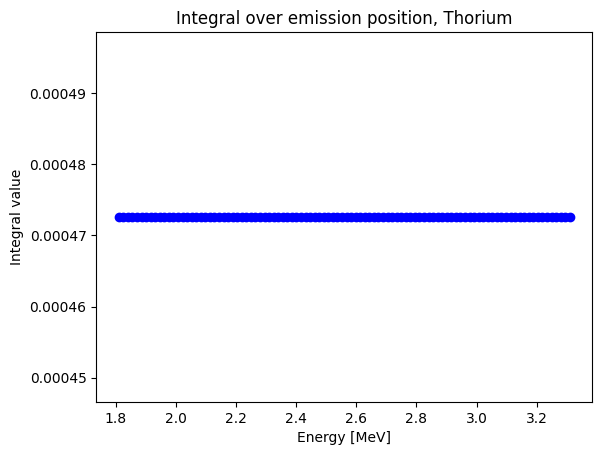

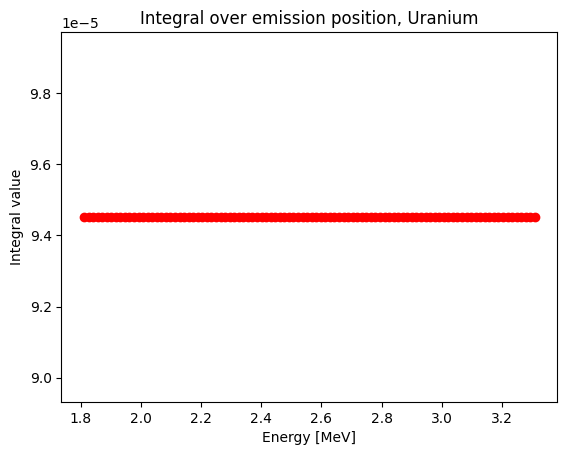

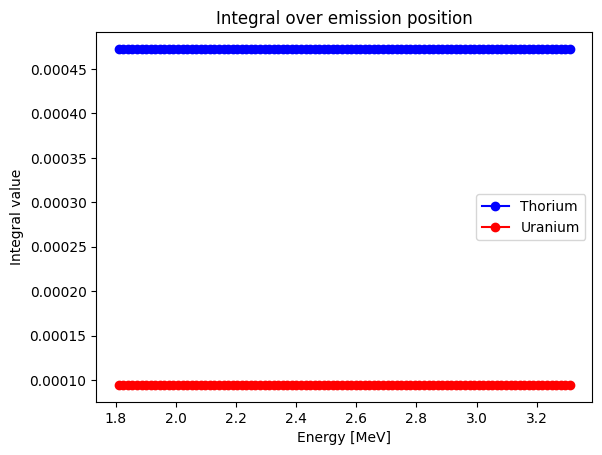

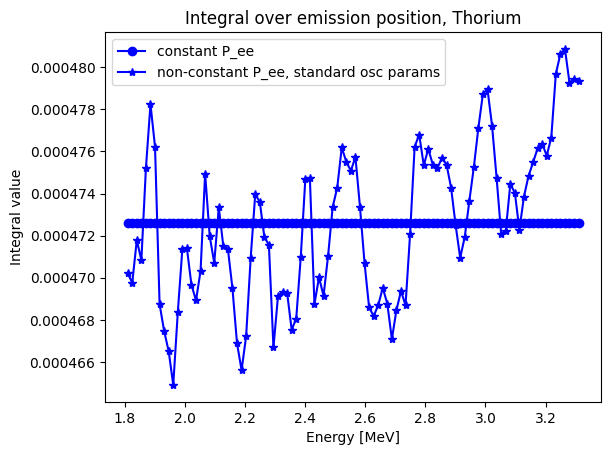

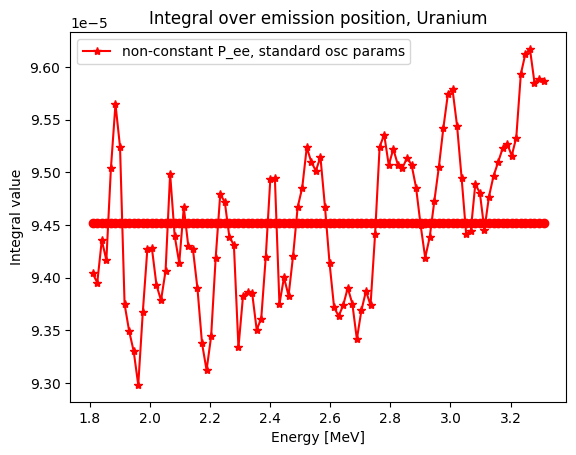

In [16]:
#make plots, just for integrals with constant P_ee
print("making plots")
#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
plt.show()
#make plots to compare integral for constant P_ee and non-constant(dependent on energy and oscillation parameters)

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='b', label='constant P_ee')
plt.plot(energy_array, Th_integral_values_c, marker='*', linestyle='-', color='b', label='non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.legend()
#plt.savefig('Thorium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_c, marker='o', linestyle='-', color='r')
plt.plot(energy_array, U_integral_values_c, marker='*', linestyle='-', color='r', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.legend()
#plt.savefig('Uranium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

In [17]:
def sigma_IBD(energy_array):
    # optimized with numpy
    
    m_e = 0.511 #MeV
    m_p = 938 #MeV
    m_n = 941 #MeV
    E_th = 1.8 #MeV
    
    sigma = ((energy_array - E_th + m_e)**2) * ((1 - (m_e)**2/((energy_array - E_th + m_e)**2))**(1/2))
    
    return sigma
#all these + sources in Earth model more bins -3 (for example)

In [18]:
print("setting lambda and mu values")

lambda_U = 4.916
lambda_Th = 1.563
mu_U = 235
mu_Th = 232

setting lambda and mu values


getting emission fluxes


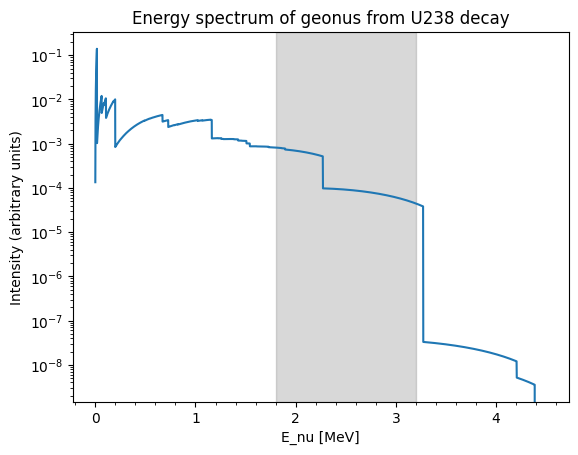

done for Uranium, moving on to Thorium


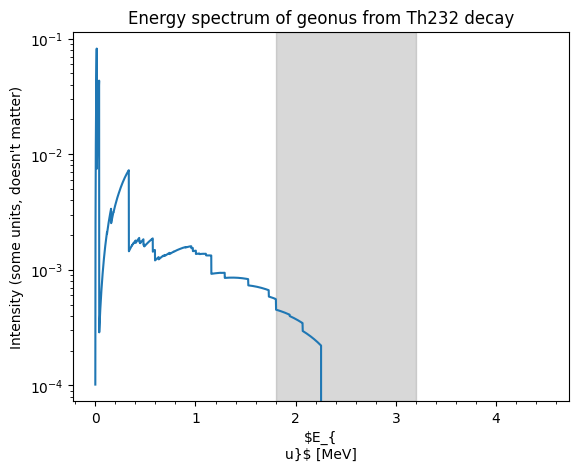

rebin to match energy array


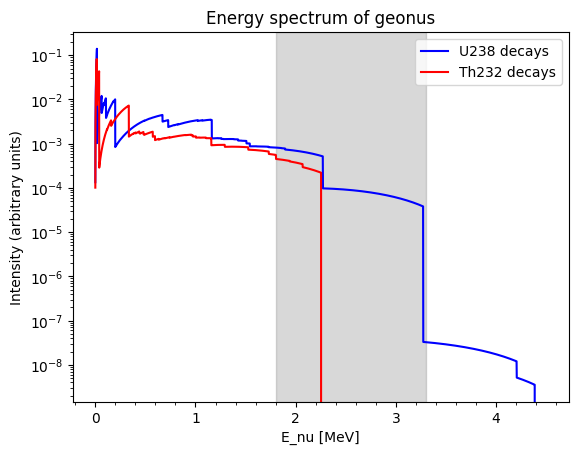

In [19]:

#get fluxes
print("getting emission fluxes")
energy_array_U = []
dn_dE_U = []

with open('U238_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_U.append(float(columns[0]))
        dn_dE_U.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_U = np.array(energy_array_U) / 1000
dn_dE_U = np.array(dn_dE_U)

plt.plot(energy_array_U, dn_dE_U)
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (arbitrary units)')
plt.title('Energy spectrum of geonus from U238 decay')
# 
# Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')
# Enable minor ticks on x-axis
plt.minorticks_on()
#plt.savefig("Emission.pdf", format='pdf')
plt.show()

print("done for Uranium, moving on to Thorium")

energy_array_Th = []
dn_dE_Th = []
with open('Th232_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_Th.append(float(columns[0]))
        dn_dE_Th.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_Th = np.array(energy_array_Th) / 1000
dn_dE_Th = np.array(dn_dE_Th)

plt.plot(energy_array_Th, dn_dE_Th)
plt.xlabel('$E_{\nu}$ [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus from Th232 decay')
# # Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')
# # Enable minor ticks on x-axis
plt.minorticks_on()
plt.show()
# Plot U238 decay data (blue line)
plt.plot(energy_array_U, dn_dE_U, label='U238 decays', color='blue')
# 
# # Plot Th232 decay data (red line)
plt.plot(energy_array_Th, dn_dE_Th, label='Th232 decays', color='red')
# 
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (arbitrary units)')
plt.title('Energy spectrum of geonus')
# 
# # Add shaded region between 1.8 MeV and 3.3 MeV
plt.axvspan(1.8, 3.3, alpha=0.3, color='gray')
# 
# # Enable minor ticks on x-axis
plt.minorticks_on()
# 
plt.legend(loc='upper right')
# 
#plt.show()

#plt.savefig("Emission.pdf", format='pdf')
def rebin_counts(initial_bins, counts_in_initial_bins, final_bin_midpoints):
    """
    Rebins counts data.

    Parameters:
    - initial_bins: array, bin edges of the initial data
    - counts_in_initial_bins: array, counts in each initial bin
    - final_bin_midpoints: array, midpoints of the final desired bins

    Returns:
    - counts_in_final_bins: array, counts in each final bin
    """

    # Calculate bin midpoints of the initial bins
    bin_midpoints = (initial_bins[:-1] + initial_bins[1:]) / 2

    # Use np.histogram to calculate counts in final bins
    counts_in_final_bins, _ = np.histogram(initial_bins, bins=np.concatenate([initial_bins, [2 * initial_bins[-1] - initial_bins[-2]]]), weights=counts_in_initial_bins)

    # Interpolate the counts to the final bin midpoints
    counts_in_final_bins = np.interp(final_bin_midpoints, bin_midpoints, counts_in_final_bins[:-1])

    return counts_in_final_bins

print("rebin to match energy array")

dn_dE_rebinned_U = rebin_counts(energy_array_U, dn_dE_U, energy_array)
dn_dE_rebinned_Th = rebin_counts(energy_array_Th, dn_dE_Th, energy_array)

In [20]:
print("computing IBD cross section")
sigma = sigma_IBD(energy_array)

computing IBD cross section


Compute total fluxes coming from crust - same as Mantle layering:

In [21]:
print("computing fluxes at detector (standard oscillation parameters, crust contribution only")
N_Th_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_c
N_U_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_c
   
### special cell

computing fluxes at detector (standard oscillation parameters, crust contribution only


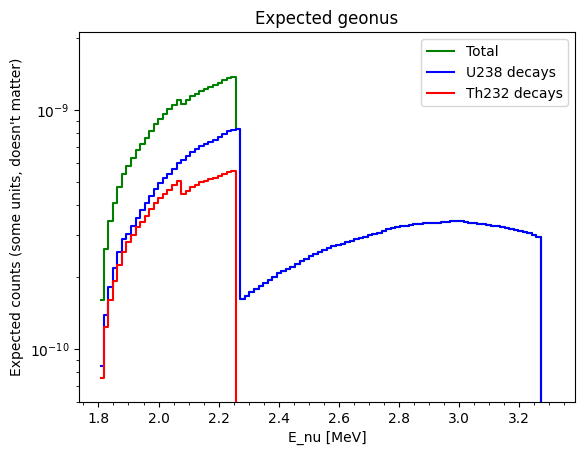

In [22]:
# Plot histogram for both
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total', color='green')
plt.step(energy_array, N_U_c, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th_c, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


In [23]:
print("computing fluxes at detector (constant P_ee, crust contribution only")
N_Th_constant_P_ee_mid_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_mid_c
N_U_constant_P_ee_mid_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_mid_c
    
N_Th_constant_P_ee_low_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_low_c
N_U_constant_P_ee_low_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_low_c
    
N_Th_constant_P_ee_high_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_high_c
N_U_constant_P_ee_high_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_high_c
    

computing fluxes at detector (constant P_ee, crust contribution only


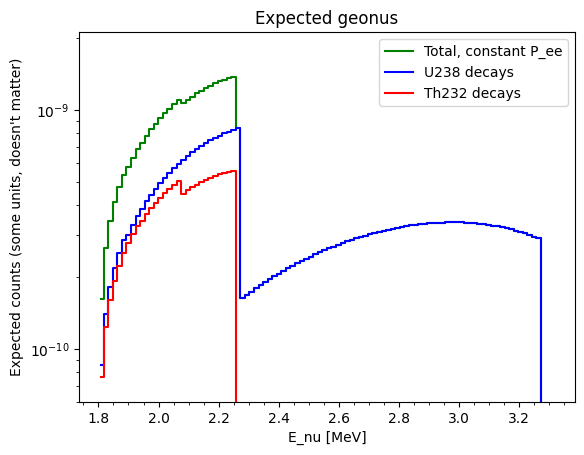

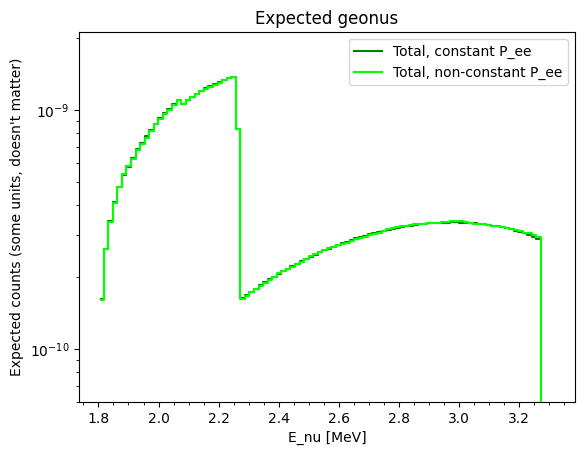

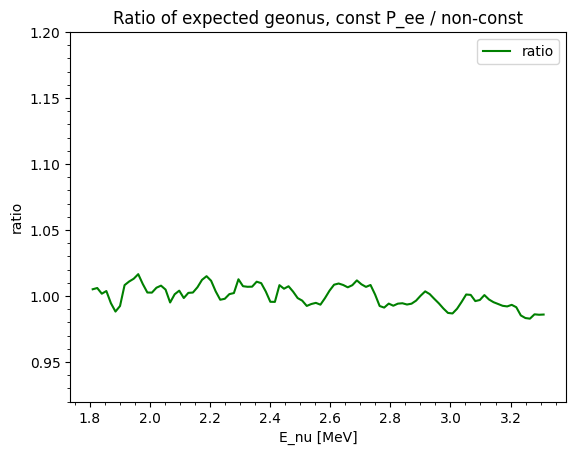

In [24]:
# Plot histogram for both, constant P_ee only
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U_constant_P_ee_mid_c, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th_constant_P_ee_mid_c, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()
#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total, non-constant P_ee', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#plt.savefig('Expected counts, standard params vs constant P_ee.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c) / (N_U_c + N_Th_c), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-12)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee.pdf', format='pdf')

plt.show()
# we did this for the crust, now want to do this for the mantle as well
# mantle grid too big, restrict distances
# adjust size as required

Now, everything so far MUST be the same, because we didn't change anything about the crust. If everything so far is NOT, the same, something is INCREDIBLY wrong. I will run both up until this point to check that everything is indeed identical



Everything is indeed identical so far: the next cell (CLM calculation) is also copied; then, we have to modify the calculation for the DM and EM bits

In [25]:
print("computing integrals for standard oscillation parameters, CLM contribution only")

Th_integral_values_CLM, U_integral_values_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_CLM, A_U_CLM, rho_CLM)

computing integrals for standard oscillation parameters, CLM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2784.22 MB
deleted
Current memory usage: 2784.22 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 4568.26 MB
deleted
Current memory usage: 4568.26 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2785.24 MB
deleted
Current memory usage: 930.01 MB


In [26]:
print("computing integrals for standard oscillation parameters, DM contribution only")

Th_integral_values_DM1, U_integral_values_DM1 = integral_over_positions_Th_U(DM_grids[0], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM2, U_integral_values_DM2 = integral_over_positions_Th_U(DM_grids[1], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM3, U_integral_values_DM3 = integral_over_positions_Th_U(DM_grids[2], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM4, U_integral_values_DM4 = integral_over_positions_Th_U(DM_grids[3], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM5, U_integral_values_DM5 = integral_over_positions_Th_U(DM_grids[4], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM6, U_integral_values_DM6 = integral_over_positions_Th_U(DM_grids[5], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM7, U_integral_values_DM7 = integral_over_positions_Th_U(DM_grids[6], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM8, U_integral_values_DM8 = integral_over_positions_Th_U(DM_grids[7], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM9, U_integral_values_DM9 = integral_over_positions_Th_U(DM_grids[8], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM10, U_integral_values_DM10 = integral_over_positions_Th_U(DM_grids[9], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM11, U_integral_values_DM11 = integral_over_positions_Th_U(DM_grids[10], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM12, U_integral_values_DM12 = integral_over_positions_Th_U(DM_grids[11], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM13, U_integral_values_DM13 = integral_over_positions_Th_U(DM_grids[12], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM14, U_integral_values_DM14 = integral_over_positions_Th_U(DM_grids[13], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM15, U_integral_values_DM15 = integral_over_positions_Th_U(DM_grids[14], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM16, U_integral_values_DM16 = integral_over_positions_Th_U(DM_grids[15], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM17, U_integral_values_DM17 = integral_over_positions_Th_U(DM_grids[16], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM18, U_integral_values_DM18 = integral_over_positions_Th_U(DM_grids[17], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM19, U_integral_values_DM19 = integral_over_positions_Th_U(DM_grids[18], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_DM = (
    Th_integral_values_DM1 + Th_integral_values_DM2 + Th_integral_values_DM3 + 
    Th_integral_values_DM4 + Th_integral_values_DM5 + Th_integral_values_DM6 + 
    Th_integral_values_DM7 + Th_integral_values_DM8 + Th_integral_values_DM9 + 
    Th_integral_values_DM10 + Th_integral_values_DM11 + Th_integral_values_DM12 + 
    Th_integral_values_DM13 + Th_integral_values_DM14 + Th_integral_values_DM15 + 
    Th_integral_values_DM16 + Th_integral_values_DM17 + Th_integral_values_DM18 + 
    Th_integral_values_DM19
)

U_integral_values_DM = (
    U_integral_values_DM1 + U_integral_values_DM2 + U_integral_values_DM3 + 
    U_integral_values_DM4 + U_integral_values_DM5 + U_integral_values_DM6 + 
    U_integral_values_DM7 + U_integral_values_DM8 + U_integral_values_DM9 + 
    U_integral_values_DM10 + U_integral_values_DM11 + U_integral_values_DM12 + 
    U_integral_values_DM13 + U_integral_values_DM14 + U_integral_values_DM15 + 
    U_integral_values_DM16 + U_integral_values_DM17 + U_integral_values_DM18 + 
    U_integral_values_DM19
)


computing integrals for standard oscillation parameters, DM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1492.34 MB
deleted
Current memory usage: 1492.34 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2013.25 MB
deleted
Current memory usage: 2013.25 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1492.30 MB
deleted
Current memory usage: 971.38 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative dist

In [27]:
print('computed; deleting useless stuff')
print(f"Current memory usage: {get_memory_usage():.2f} MB")
del U_integral_values_DM1, U_integral_values_DM2, U_integral_values_DM3, U_integral_values_DM4, U_integral_values_DM5, U_integral_values_DM6, U_integral_values_DM7, U_integral_values_DM8, U_integral_values_DM9, U_integral_values_DM10, U_integral_values_DM11, U_integral_values_DM12, U_integral_values_DM13, U_integral_values_DM14, U_integral_values_DM15, U_integral_values_DM16, U_integral_values_DM17, U_integral_values_DM18, U_integral_values_DM19
del Th_integral_values_DM1, Th_integral_values_DM2, Th_integral_values_DM3, Th_integral_values_DM4, Th_integral_values_DM5, Th_integral_values_DM6, Th_integral_values_DM7, Th_integral_values_DM8, Th_integral_values_DM9, Th_integral_values_DM10, Th_integral_values_DM11, Th_integral_values_DM12, Th_integral_values_DM13, Th_integral_values_DM14, Th_integral_values_DM15, Th_integral_values_DM16, Th_integral_values_DM17, Th_integral_values_DM18, Th_integral_values_DM19
print('deleted')
print(f"Current memory usage: {get_memory_usage():.2f} MB")

computed; deleting useless stuff
Current memory usage: 961.73 MB
deleted
Current memory usage: 961.73 MB


The thing above took half a second longer (5s 353 ms instead of 4s 851ms) but seems good so far! Let's keep going

In [28]:
print("computing integrals for standard oscillation parameters, EM contribution only")

Th_integral_values_EM1, U_integral_values_EM1 = integral_over_positions_Th_U(EM_grids[0], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_EM2, U_integral_values_EM2 = integral_over_positions_Th_U(EM_grids[1], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_EM3, U_integral_values_EM3 = integral_over_positions_Th_U(EM_grids[2], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_EM4, U_integral_values_EM4 = integral_over_positions_Th_U(EM_grids[3], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_EM5, U_integral_values_EM5 = integral_over_positions_Th_U(EM_grids[4], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_EM6, U_integral_values_EM6 = integral_over_positions_Th_U(EM_grids[5], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_EM7, U_integral_values_EM7 = integral_over_positions_Th_U(EM_grids[6], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)



Th_integral_values_EM = (
    Th_integral_values_EM1 + Th_integral_values_EM2 + Th_integral_values_EM3 + 
    Th_integral_values_EM4 + Th_integral_values_EM5 + Th_integral_values_EM6 + 
    Th_integral_values_EM7
)

U_integral_values_EM = (
    U_integral_values_EM1 + U_integral_values_EM2 + U_integral_values_EM3 + 
    U_integral_values_EM4 + U_integral_values_EM5 + U_integral_values_EM6 + 
    U_integral_values_EM7
)



computing integrals for standard oscillation parameters, EM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1407.64 MB
deleted
Current memory usage: 1407.64 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1850.24 MB
deleted
Current memory usage: 1850.24 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1407.68 MB
deleted
Current memory usage: 965.08 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative dist

The cell above took 2s 704ms instead of 988ms. Again, reasonable difference; All the next cells should be the same, so we should be ready for the final comparison!

In [29]:
print(" computing total contribution ")
Th_integral_values_m = Th_integral_values_CLM + Th_integral_values_EM + Th_integral_values_DM
U_integral_values_m = U_integral_values_CLM + U_integral_values_EM + U_integral_values_DM

 computing total contribution 


Ah, except the constant ones which will be a pain in the ass .... 

In [30]:
print("computing integrals for constant P_ee, CLM contribution only")
Th_integral_values_constant_P_ee_mid_CLM, U_integral_values_constant_P_ee_mid_CLM, Th_integral_values_constant_P_ee_low_CLM, U_integral_values_constant_P_ee_low_CLM, Th_integral_values_constant_P_ee_high_CLM, U_integral_values_constant_P_ee_high_CLM = integral_over_positions_Th_U_constant_P_ee (CLM_grid, energy_array, grid_1d_size_mantle, A_Th_CLM, A_U_CLM, rho_CLM)

computing integrals for constant P_ee, CLM contribution only
   
Computed relative distances from Earth grid points to SNO+
   


In [31]:
print("computing integrals for constant P_ee, DM contribution only")

Th_integral_values_constant_P_ee_mid_DM1, U_integral_values_constant_P_ee_mid_DM1, Th_integral_values_constant_P_ee_low_DM1, U_integral_values_constant_P_ee_low_DM1, Th_integral_values_constant_P_ee_high_DM1, U_integral_values_constant_P_ee_high_DM1 = integral_over_positions_Th_U_constant_P_ee(DM_grids[0], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM2, U_integral_values_constant_P_ee_mid_DM2, Th_integral_values_constant_P_ee_low_DM2, U_integral_values_constant_P_ee_low_DM2, Th_integral_values_constant_P_ee_high_DM2, U_integral_values_constant_P_ee_high_DM2 = integral_over_positions_Th_U_constant_P_ee(DM_grids[1], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM3, U_integral_values_constant_P_ee_mid_DM3, Th_integral_values_constant_P_ee_low_DM3, U_integral_values_constant_P_ee_low_DM3, Th_integral_values_constant_P_ee_high_DM3, U_integral_values_constant_P_ee_high_DM3 = integral_over_positions_Th_U_constant_P_ee(DM_grids[2], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM4, U_integral_values_constant_P_ee_mid_DM4, Th_integral_values_constant_P_ee_low_DM4, U_integral_values_constant_P_ee_low_DM4, Th_integral_values_constant_P_ee_high_DM4, U_integral_values_constant_P_ee_high_DM4 = integral_over_positions_Th_U_constant_P_ee(DM_grids[3], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM5, U_integral_values_constant_P_ee_mid_DM5, Th_integral_values_constant_P_ee_low_DM5, U_integral_values_constant_P_ee_low_DM5, Th_integral_values_constant_P_ee_high_DM5, U_integral_values_constant_P_ee_high_DM5 = integral_over_positions_Th_U_constant_P_ee(DM_grids[4], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM6, U_integral_values_constant_P_ee_mid_DM6, Th_integral_values_constant_P_ee_low_DM6, U_integral_values_constant_P_ee_low_DM6, Th_integral_values_constant_P_ee_high_DM6, U_integral_values_constant_P_ee_high_DM6 = integral_over_positions_Th_U_constant_P_ee(DM_grids[5], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM7, U_integral_values_constant_P_ee_mid_DM7, Th_integral_values_constant_P_ee_low_DM7, U_integral_values_constant_P_ee_low_DM7, Th_integral_values_constant_P_ee_high_DM7, U_integral_values_constant_P_ee_high_DM7 = integral_over_positions_Th_U_constant_P_ee(DM_grids[6], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM8, U_integral_values_constant_P_ee_mid_DM8, Th_integral_values_constant_P_ee_low_DM8, U_integral_values_constant_P_ee_low_DM8, Th_integral_values_constant_P_ee_high_DM8, U_integral_values_constant_P_ee_high_DM8 = integral_over_positions_Th_U_constant_P_ee(DM_grids[7], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM9, U_integral_values_constant_P_ee_mid_DM9, Th_integral_values_constant_P_ee_low_DM9, U_integral_values_constant_P_ee_low_DM9, Th_integral_values_constant_P_ee_high_DM9, U_integral_values_constant_P_ee_high_DM9 = integral_over_positions_Th_U_constant_P_ee(DM_grids[8], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM10, U_integral_values_constant_P_ee_mid_DM10, Th_integral_values_constant_P_ee_low_DM10, U_integral_values_constant_P_ee_low_DM10, Th_integral_values_constant_P_ee_high_DM10, U_integral_values_constant_P_ee_high_DM10 = integral_over_positions_Th_U_constant_P_ee(DM_grids[9], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM11, U_integral_values_constant_P_ee_mid_DM11, Th_integral_values_constant_P_ee_low_DM11, U_integral_values_constant_P_ee_low_DM11, Th_integral_values_constant_P_ee_high_DM11, U_integral_values_constant_P_ee_high_DM11 = integral_over_positions_Th_U_constant_P_ee(DM_grids[10], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM12, U_integral_values_constant_P_ee_mid_DM12, Th_integral_values_constant_P_ee_low_DM12, U_integral_values_constant_P_ee_low_DM12, Th_integral_values_constant_P_ee_high_DM12, U_integral_values_constant_P_ee_high_DM12 = integral_over_positions_Th_U_constant_P_ee(DM_grids[11], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM13, U_integral_values_constant_P_ee_mid_DM13, Th_integral_values_constant_P_ee_low_DM13, U_integral_values_constant_P_ee_low_DM13, Th_integral_values_constant_P_ee_high_DM13, U_integral_values_constant_P_ee_high_DM13 = integral_over_positions_Th_U_constant_P_ee(DM_grids[12], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM14, U_integral_values_constant_P_ee_mid_DM14, Th_integral_values_constant_P_ee_low_DM14, U_integral_values_constant_P_ee_low_DM14, Th_integral_values_constant_P_ee_high_DM14, U_integral_values_constant_P_ee_high_DM14 = integral_over_positions_Th_U_constant_P_ee(DM_grids[13], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM15, U_integral_values_constant_P_ee_mid_DM15, Th_integral_values_constant_P_ee_low_DM15, U_integral_values_constant_P_ee_low_DM15, Th_integral_values_constant_P_ee_high_DM15, U_integral_values_constant_P_ee_high_DM15 = integral_over_positions_Th_U_constant_P_ee(DM_grids[14], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM16, U_integral_values_constant_P_ee_mid_DM16, Th_integral_values_constant_P_ee_low_DM16, U_integral_values_constant_P_ee_low_DM16, Th_integral_values_constant_P_ee_high_DM16, U_integral_values_constant_P_ee_high_DM16 = integral_over_positions_Th_U_constant_P_ee(DM_grids[15], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM17, U_integral_values_constant_P_ee_mid_DM17, Th_integral_values_constant_P_ee_low_DM17, U_integral_values_constant_P_ee_low_DM17, Th_integral_values_constant_P_ee_high_DM17, U_integral_values_constant_P_ee_high_DM17 = integral_over_positions_Th_U_constant_P_ee(DM_grids[16], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM18, U_integral_values_constant_P_ee_mid_DM18, Th_integral_values_constant_P_ee_low_DM18, U_integral_values_constant_P_ee_low_DM18, Th_integral_values_constant_P_ee_high_DM18, U_integral_values_constant_P_ee_high_DM18 = integral_over_positions_Th_U_constant_P_ee(DM_grids[17], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_constant_P_ee_mid_DM19, U_integral_values_constant_P_ee_mid_DM19, Th_integral_values_constant_P_ee_low_DM19, U_integral_values_constant_P_ee_low_DM19, Th_integral_values_constant_P_ee_high_DM19, U_integral_values_constant_P_ee_high_DM19 = integral_over_positions_Th_U_constant_P_ee(DM_grids[18], energy_array, grid_1d_size_mantle, A_Th_DM, A_U_DM, rho_DM)


Th_integral_values_constant_P_ee_mid_DM = (
    Th_integral_values_constant_P_ee_mid_DM1 + Th_integral_values_constant_P_ee_mid_DM2 + 
    Th_integral_values_constant_P_ee_mid_DM3 + Th_integral_values_constant_P_ee_mid_DM4 + 
    Th_integral_values_constant_P_ee_mid_DM5 + Th_integral_values_constant_P_ee_mid_DM6 + 
    Th_integral_values_constant_P_ee_mid_DM7 + Th_integral_values_constant_P_ee_mid_DM8 + 
    Th_integral_values_constant_P_ee_mid_DM9 + Th_integral_values_constant_P_ee_mid_DM10 + 
    Th_integral_values_constant_P_ee_mid_DM11 + Th_integral_values_constant_P_ee_mid_DM12 + 
    Th_integral_values_constant_P_ee_mid_DM13 + Th_integral_values_constant_P_ee_mid_DM14 + 
    Th_integral_values_constant_P_ee_mid_DM15 + Th_integral_values_constant_P_ee_mid_DM16 + 
    Th_integral_values_constant_P_ee_mid_DM17 + Th_integral_values_constant_P_ee_mid_DM18 + 
    Th_integral_values_constant_P_ee_mid_DM19
)

Th_integral_values_constant_P_ee_low_DM = (
    Th_integral_values_constant_P_ee_low_DM1 + Th_integral_values_constant_P_ee_low_DM2 + 
    Th_integral_values_constant_P_ee_low_DM3 + Th_integral_values_constant_P_ee_low_DM4 + 
    Th_integral_values_constant_P_ee_low_DM5 + Th_integral_values_constant_P_ee_low_DM6 + 
    Th_integral_values_constant_P_ee_low_DM7 + Th_integral_values_constant_P_ee_low_DM8 + 
    Th_integral_values_constant_P_ee_low_DM9 + Th_integral_values_constant_P_ee_low_DM10 + 
    Th_integral_values_constant_P_ee_low_DM11 + Th_integral_values_constant_P_ee_low_DM12 + 
    Th_integral_values_constant_P_ee_low_DM13 + Th_integral_values_constant_P_ee_low_DM14 + 
    Th_integral_values_constant_P_ee_low_DM15 + Th_integral_values_constant_P_ee_low_DM16 + 
    Th_integral_values_constant_P_ee_low_DM17 + Th_integral_values_constant_P_ee_low_DM18 + 
    Th_integral_values_constant_P_ee_low_DM19
)

Th_integral_values_constant_P_ee_high_DM = (
    Th_integral_values_constant_P_ee_high_DM1 + Th_integral_values_constant_P_ee_high_DM2 + 
    Th_integral_values_constant_P_ee_high_DM3 + Th_integral_values_constant_P_ee_high_DM4 + 
    Th_integral_values_constant_P_ee_high_DM5 + Th_integral_values_constant_P_ee_high_DM6 + 
    Th_integral_values_constant_P_ee_high_DM7 + Th_integral_values_constant_P_ee_high_DM8 + 
    Th_integral_values_constant_P_ee_high_DM9 + Th_integral_values_constant_P_ee_high_DM10 + 
    Th_integral_values_constant_P_ee_high_DM11 + Th_integral_values_constant_P_ee_high_DM12 + 
    Th_integral_values_constant_P_ee_high_DM13 + Th_integral_values_constant_P_ee_high_DM14 + 
    Th_integral_values_constant_P_ee_high_DM15 + Th_integral_values_constant_P_ee_high_DM16 + 
    Th_integral_values_constant_P_ee_high_DM17 + Th_integral_values_constant_P_ee_high_DM18 + 
    Th_integral_values_constant_P_ee_high_DM19
)

U_integral_values_constant_P_ee_mid_DM = (
    U_integral_values_constant_P_ee_mid_DM1 + U_integral_values_constant_P_ee_mid_DM2 + 
    U_integral_values_constant_P_ee_mid_DM3 + U_integral_values_constant_P_ee_mid_DM4 + 
    U_integral_values_constant_P_ee_mid_DM5 + U_integral_values_constant_P_ee_mid_DM6 + 
    U_integral_values_constant_P_ee_mid_DM7 + U_integral_values_constant_P_ee_mid_DM8 + 
    U_integral_values_constant_P_ee_mid_DM9 + U_integral_values_constant_P_ee_mid_DM10 + 
    U_integral_values_constant_P_ee_mid_DM11 + U_integral_values_constant_P_ee_mid_DM12 + 
    U_integral_values_constant_P_ee_mid_DM13 + U_integral_values_constant_P_ee_mid_DM14 + 
    U_integral_values_constant_P_ee_mid_DM15 + U_integral_values_constant_P_ee_mid_DM16 + 
    U_integral_values_constant_P_ee_mid_DM17 + U_integral_values_constant_P_ee_mid_DM18 + 
    U_integral_values_constant_P_ee_mid_DM19
)

U_integral_values_constant_P_ee_low_DM = (
    U_integral_values_constant_P_ee_low_DM1 + U_integral_values_constant_P_ee_low_DM2 + 
    U_integral_values_constant_P_ee_low_DM3 + U_integral_values_constant_P_ee_low_DM4 + 
    U_integral_values_constant_P_ee_low_DM5 + U_integral_values_constant_P_ee_low_DM6 + 
    U_integral_values_constant_P_ee_low_DM7 + U_integral_values_constant_P_ee_low_DM8 + 
    U_integral_values_constant_P_ee_low_DM9 + U_integral_values_constant_P_ee_low_DM10 + 
    U_integral_values_constant_P_ee_low_DM11 + U_integral_values_constant_P_ee_low_DM12 + 
    U_integral_values_constant_P_ee_low_DM13 + U_integral_values_constant_P_ee_low_DM14 + 
    U_integral_values_constant_P_ee_low_DM15 + U_integral_values_constant_P_ee_low_DM16 + 
    U_integral_values_constant_P_ee_low_DM17 + U_integral_values_constant_P_ee_low_DM18 + 
    U_integral_values_constant_P_ee_low_DM19
)

U_integral_values_constant_P_ee_high_DM = (
    U_integral_values_constant_P_ee_high_DM1 + U_integral_values_constant_P_ee_high_DM2 + 
    U_integral_values_constant_P_ee_high_DM3 + U_integral_values_constant_P_ee_high_DM4 + 
    U_integral_values_constant_P_ee_high_DM5 + U_integral_values_constant_P_ee_high_DM6 + 
    U_integral_values_constant_P_ee_high_DM7 + U_integral_values_constant_P_ee_high_DM8 + 
    U_integral_values_constant_P_ee_high_DM9 + U_integral_values_constant_P_ee_high_DM10 + 
    U_integral_values_constant_P_ee_high_DM11 + U_integral_values_constant_P_ee_high_DM12 + 
    U_integral_values_constant_P_ee_high_DM13 + U_integral_values_constant_P_ee_high_DM14 + 
    U_integral_values_constant_P_ee_high_DM15 + U_integral_values_constant_P_ee_high_DM16 + 
    U_integral_values_constant_P_ee_high_DM17 + U_integral_values_constant_P_ee_high_DM18 + 
    U_integral_values_constant_P_ee_high_DM19
)



computing integrals for constant P_ee, DM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
  

The times for the cell above and its equivalent in Mantle Layering are very very similar, which is a good sign. Now EM:

In [32]:
print("computing integrals for constant P_ee, EM contribution only")

Th_integral_values_constant_P_ee_mid_EM1, U_integral_values_constant_P_ee_mid_EM1, Th_integral_values_constant_P_ee_low_EM1, U_integral_values_constant_P_ee_low_EM1, Th_integral_values_constant_P_ee_high_EM1, U_integral_values_constant_P_ee_high_EM1 = integral_over_positions_Th_U_constant_P_ee(EM_grids[0], energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_constant_P_ee_mid_EM2, U_integral_values_constant_P_ee_mid_EM2, Th_integral_values_constant_P_ee_low_EM2, U_integral_values_constant_P_ee_low_EM2, Th_integral_values_constant_P_ee_high_EM2, U_integral_values_constant_P_ee_high_EM2 = integral_over_positions_Th_U_constant_P_ee(EM_grids[1], energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_constant_P_ee_mid_EM3, U_integral_values_constant_P_ee_mid_EM3, Th_integral_values_constant_P_ee_low_EM3, U_integral_values_constant_P_ee_low_EM3, Th_integral_values_constant_P_ee_high_EM3, U_integral_values_constant_P_ee_high_EM3 = integral_over_positions_Th_U_constant_P_ee(EM_grids[2], energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_constant_P_ee_mid_EM4, U_integral_values_constant_P_ee_mid_EM4, Th_integral_values_constant_P_ee_low_EM4, U_integral_values_constant_P_ee_low_EM4, Th_integral_values_constant_P_ee_high_EM4, U_integral_values_constant_P_ee_high_EM4 = integral_over_positions_Th_U_constant_P_ee(EM_grids[3], energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_constant_P_ee_mid_EM5, U_integral_values_constant_P_ee_mid_EM5, Th_integral_values_constant_P_ee_low_EM5, U_integral_values_constant_P_ee_low_EM5, Th_integral_values_constant_P_ee_high_EM5, U_integral_values_constant_P_ee_high_EM5 = integral_over_positions_Th_U_constant_P_ee(EM_grids[4], energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_constant_P_ee_mid_EM6, U_integral_values_constant_P_ee_mid_EM6, Th_integral_values_constant_P_ee_low_EM6, U_integral_values_constant_P_ee_low_EM6, Th_integral_values_constant_P_ee_high_EM6, U_integral_values_constant_P_ee_high_EM6 = integral_over_positions_Th_U_constant_P_ee(EM_grids[5], energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_constant_P_ee_mid_EM7, U_integral_values_constant_P_ee_mid_EM7, Th_integral_values_constant_P_ee_low_EM7, U_integral_values_constant_P_ee_low_EM7, Th_integral_values_constant_P_ee_high_EM7, U_integral_values_constant_P_ee_high_EM7 = integral_over_positions_Th_U_constant_P_ee(EM_grids[6], energy_array, grid_1d_size_mantle, A_Th_EM, A_U_EM, rho_EM)


Th_integral_values_constant_P_ee_mid_EM = (
    Th_integral_values_constant_P_ee_mid_EM1 + Th_integral_values_constant_P_ee_mid_EM2 + 
    Th_integral_values_constant_P_ee_mid_EM3 + Th_integral_values_constant_P_ee_mid_EM4 + 
    Th_integral_values_constant_P_ee_mid_EM5 + Th_integral_values_constant_P_ee_mid_EM6 + 
    Th_integral_values_constant_P_ee_mid_EM7
)

Th_integral_values_constant_P_ee_low_EM = (
    Th_integral_values_constant_P_ee_low_EM1 + Th_integral_values_constant_P_ee_low_EM2 + 
    Th_integral_values_constant_P_ee_low_EM3 + Th_integral_values_constant_P_ee_low_EM4 + 
    Th_integral_values_constant_P_ee_low_EM5 + Th_integral_values_constant_P_ee_low_EM6 + 
    Th_integral_values_constant_P_ee_low_EM7
)

Th_integral_values_constant_P_ee_high_EM = (
    Th_integral_values_constant_P_ee_high_EM1 + Th_integral_values_constant_P_ee_high_EM2 + 
    Th_integral_values_constant_P_ee_high_EM3 + Th_integral_values_constant_P_ee_high_EM4 + 
    Th_integral_values_constant_P_ee_high_EM5 + Th_integral_values_constant_P_ee_high_EM6 + 
    Th_integral_values_constant_P_ee_high_EM7
)

U_integral_values_constant_P_ee_mid_EM = (
    U_integral_values_constant_P_ee_mid_EM1 + U_integral_values_constant_P_ee_mid_EM2 + 
    U_integral_values_constant_P_ee_mid_EM3 + U_integral_values_constant_P_ee_mid_EM4 + 
    U_integral_values_constant_P_ee_mid_EM5 + U_integral_values_constant_P_ee_mid_EM6 + 
    U_integral_values_constant_P_ee_mid_EM7
)

U_integral_values_constant_P_ee_low_EM = (
    U_integral_values_constant_P_ee_low_EM1 + U_integral_values_constant_P_ee_low_EM2 + 
    U_integral_values_constant_P_ee_low_EM3 + U_integral_values_constant_P_ee_low_EM4 + 
    U_integral_values_constant_P_ee_low_EM5 + U_integral_values_constant_P_ee_low_EM6 + 
    U_integral_values_constant_P_ee_low_EM7
)

U_integral_values_constant_P_ee_high_EM = (
    U_integral_values_constant_P_ee_high_EM1 + U_integral_values_constant_P_ee_high_EM2 + 
    U_integral_values_constant_P_ee_high_EM3 + U_integral_values_constant_P_ee_high_EM4 + 
    U_integral_values_constant_P_ee_high_EM5 + U_integral_values_constant_P_ee_high_EM6 + 
    U_integral_values_constant_P_ee_high_EM7
)


computing integrals for constant P_ee, EM contribution only
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   


This one took 1s 519ms instead of 515ms but still reasonable. The next cell just adds up the contributions from the big layers so it should all be the same; NOW (actually this time) we can check whether all the plots match

In [33]:
print(" computing total contribution ")

Th_integral_values_constant_P_ee_mid_m = Th_integral_values_constant_P_ee_mid_CLM + Th_integral_values_constant_P_ee_mid_DM + Th_integral_values_constant_P_ee_mid_EM
Th_integral_values_constant_P_ee_low_m = Th_integral_values_constant_P_ee_low_CLM + Th_integral_values_constant_P_ee_low_DM + Th_integral_values_constant_P_ee_low_EM
Th_integral_values_constant_P_ee_high_m = Th_integral_values_constant_P_ee_high_CLM + Th_integral_values_constant_P_ee_high_DM + Th_integral_values_constant_P_ee_high_EM

U_integral_values_constant_P_ee_mid_m = U_integral_values_constant_P_ee_mid_CLM + U_integral_values_constant_P_ee_mid_DM + U_integral_values_constant_P_ee_mid_EM
U_integral_values_constant_P_ee_low_m = U_integral_values_constant_P_ee_low_CLM + U_integral_values_constant_P_ee_low_DM + U_integral_values_constant_P_ee_low_EM
U_integral_values_constant_P_ee_high_m = U_integral_values_constant_P_ee_high_CLM + U_integral_values_constant_P_ee_high_DM + U_integral_values_constant_P_ee_high_EM

 computing total contribution 


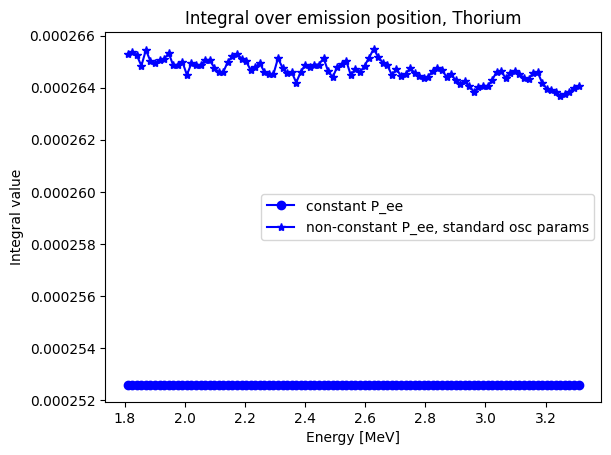

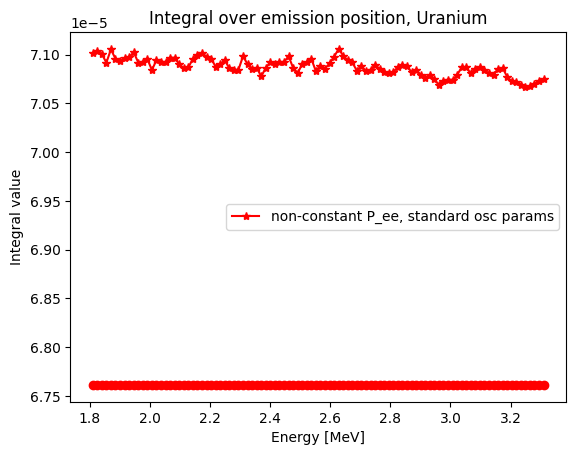

In [34]:
#make plots to compare integral for constant P_ee and non-constant(dependent on energy and oscillation parameters)

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee_mid_m, marker='o', linestyle='-', color='b', label='constant P_ee')
plt.plot(energy_array, Th_integral_values_m, marker='*', linestyle='-', color='b', label='non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.legend()
#plt.savefig('Thorium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee_mid_m, marker='o', linestyle='-', color='r')
plt.plot(energy_array, U_integral_values_m, marker='*', linestyle='-', color='r', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.legend()
#plt.savefig('Uranium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

THEY DON'T MATCH AT ALL!!!! FUCK!!!! what the hell is wrong with these? I don't get it ........... there must be something uper wrong with my method......

In [35]:
# CODE USED TO END HERE FOR TESTING
# adding other bits

In [36]:
print("computing fluxes at detector location")

N_Th_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_m
N_U_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_m

N_Th_constant_P_ee_mid_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_mid_m
N_U_constant_P_ee_mid_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_mid_m

N_Th_constant_P_ee_low_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_low_m
N_U_constant_P_ee_low_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_low_m

N_Th_constant_P_ee_high_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_constant_P_ee_high_m
N_U_constant_P_ee_high_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_constant_P_ee_high_m

computing fluxes at detector location


plotting comparison between constant P_ee and standard oscillation parameters


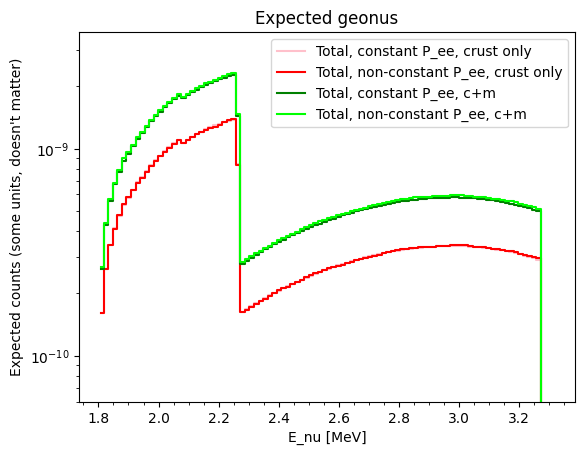

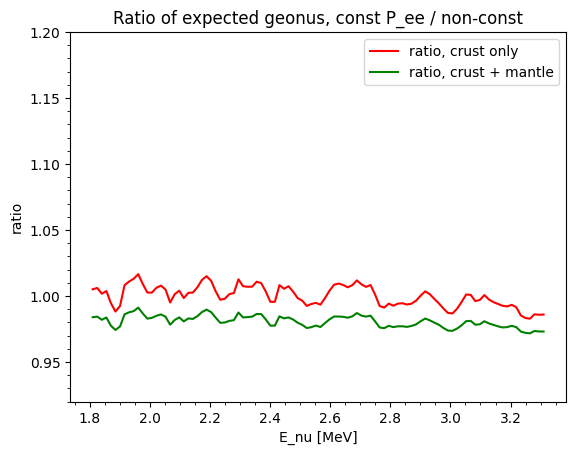

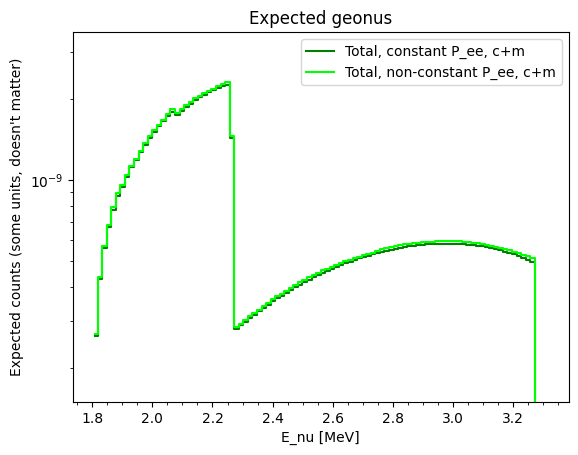

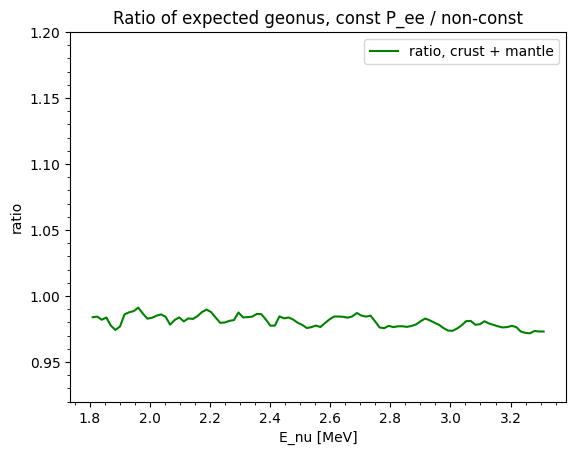

plots saved


In [37]:
#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

print("plotting comparison between constant P_ee and standard oscillation parameters")

plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee, crust only', color='pink')
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total, non-constant P_ee, crust only', color='red')
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#crust versus crust+mantle comparison
plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c) / (N_U_c + N_Th_c), label='ratio, crust only', color='red')
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#crust versus crust+mantle comparison
plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, comparison, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1.5e-10)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#crust versus crust+mantle comparison
plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#constant P_ee versus standard oscillation parameters
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved")

plotting comparison between constant P_ee and standard oscillation parameters


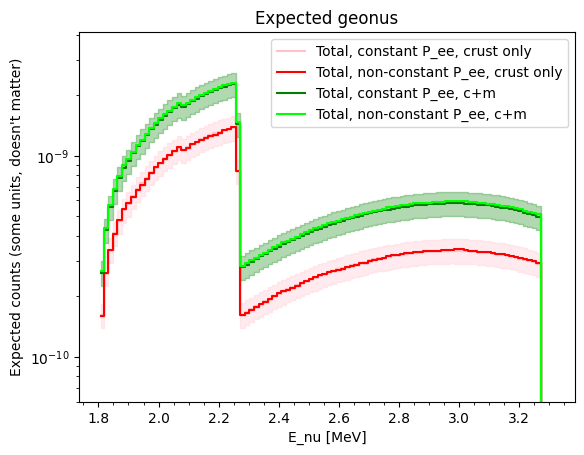

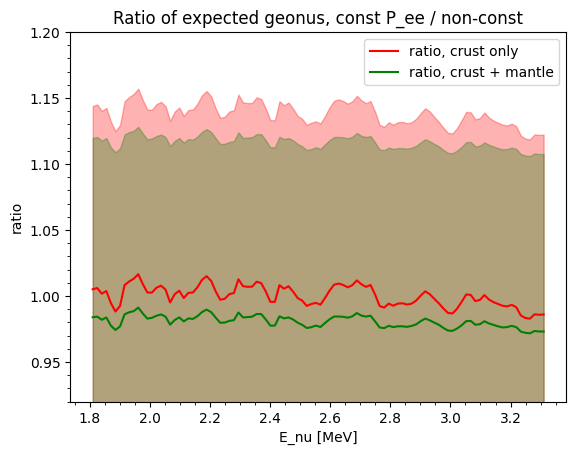

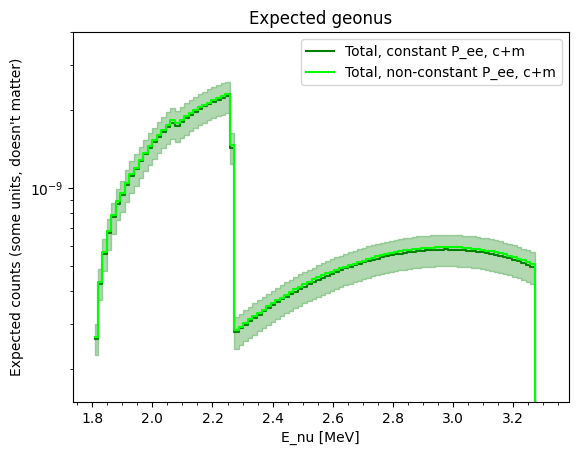

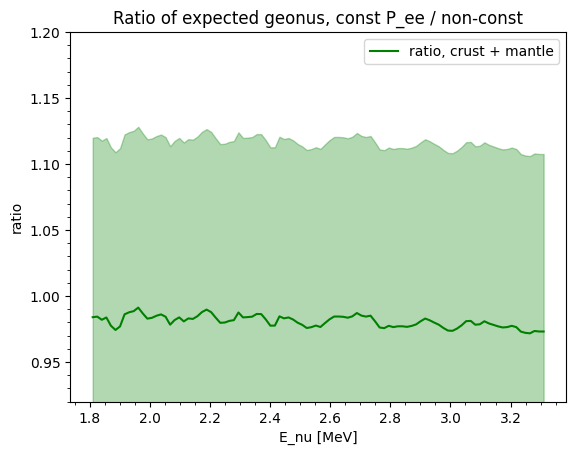

plots saved


In [38]:
print("plotting comparison between constant P_ee and standard oscillation parameters")

# First plot with shaded bands
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c, where='mid', label='Total, constant P_ee, crust only', color='pink')
plt.fill_between(energy_array, N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c, N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c, step='mid', color='pink', alpha=0.3)
plt.step(energy_array, N_U_c + N_Th_c, where='mid', label='Total, non-constant P_ee, crust only', color='red')
plt.fill_between(energy_array, N_U_c + N_Th_c, N_U_c + N_Th_c, step='mid', color='red', alpha=0.3)
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.fill_between(energy_array, N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m, N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m, step='mid', color='green', alpha=0.3)
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')
plt.fill_between(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, N_U_c + N_Th_c + N_U_m + N_Th_m, step='mid', color='lime', alpha=0.3)

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

# Second plot with shaded bands
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c) / (N_U_c + N_Th_c), label='ratio, crust only', color='red')
plt.fill_between(energy_array, (N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c) / (N_U_c + N_Th_c), (N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c) / (N_U_c + N_Th_c), color='red', alpha=0.3)
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.fill_between(energy_array, (N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), (N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), color='green', alpha=0.3)
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, comparison, Detailed Mantle.pdf', format='pdf')

plt.show()

# Third plot with shaded bands
plt.step(energy_array, N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m, where='mid', label='Total, constant P_ee, c+m', color='green')
plt.fill_between(energy_array, N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m, N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m, step='mid', color='green', alpha=0.3)
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='Total, non-constant P_ee, c+m', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1.5e-10)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Expected counts, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

# Fourth plot with shaded bands
plt.plot(energy_array, (N_U_constant_P_ee_mid_c + N_Th_constant_P_ee_mid_c + N_U_constant_P_ee_mid_m + N_Th_constant_P_ee_mid_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio, crust + mantle', color='green')
plt.fill_between(energy_array, (N_U_constant_P_ee_low_c + N_Th_constant_P_ee_low_c + N_U_constant_P_ee_low_m + N_Th_constant_P_ee_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), (N_U_constant_P_ee_high_c + N_Th_constant_P_ee_high_c + N_U_constant_P_ee_high_m + N_Th_constant_P_ee_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), color='green', alpha=0.3)
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

# Save figure
#plt.savefig('Ratio of expected geonus, standard params vs constant P_ee, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved")

In [39]:
def integral_over_pos_weights(points_array, energy_array, grid_1d_size, A_Th, A_U, rho):
    dV = grid_1d_size ** 3

    relative_distance_array = calc_relative_dist(points_array)

    # Compute sum_Th and sum_U
    sum_Th = np.sum(((A_Th * rho) / (4 * np.pi * (relative_distance_array ** 2)))[np.newaxis, :] * dV, axis=1)
    sum_U = np.sum(((A_U * rho) / (4 * np.pi * (relative_distance_array ** 2)))[np.newaxis, :] * dV, axis=1)

    return sum_Th, sum_U
    


In [40]:
w_sum_Th_c, w_sum_U_c = integral_over_pos_weights(crust_grid, energy_array, grid_1d_size_crust, A_Th_c, A_U_c, rho_c)
w_sum_Th_c, w_sum_U_c = integral_over_pos_weights(crust_grid, energy_array, grid_1d_size_mantle, A_Th_c, A_U_c, rho_c)

   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   


In [41]:
print("setting alternative oscillation parameters")

theta_12_low = theta_12 * 0.9  #rad; do +- 10% now
print("theta_12_low: " + str(theta_12_low))
theta_12_high = theta_12 * 1.1
print("theta_12_high: " + str(theta_12_high))

#delta_m_21_squared_low = 5 * 10**(-5) #eV^2
delta_m_21_squared_low = delta_m_21_squared - 0.2 * 10 ** (-5)
print("delta_m_21_squared_low: " + str(delta_m_21_squared_low))
#delta_m_21_squared_high = 1.2 * 10**(-4)
delta_m_21_squared_high = delta_m_21_squared + 0.21 * 10 ** (-5)
print("delta_m_21_squared_high: " + str(delta_m_21_squared_high))


setting alternative oscillation parameters
theta_12_low: 0.53127
theta_12_high: 0.6493300000000001
delta_m_21_squared_low: 7.190000000000001e-05
delta_m_21_squared_high: 7.6e-05


In [42]:
print("computing contribution from crust for low theta")
Th_integral_values_theta_low_c, U_integral_values_theta_low_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12_low, delta_m_21_squared, A_Th_c, A_U_c, rho_c)
print("done!! moving on ...")

computing contribution from crust for low theta
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2060.82 MB
deleted
Current memory usage: 2060.82 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 3086.80 MB
deleted
Current memory usage: 3086.80 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2060.92 MB
deleted
Current memory usage: 932.47 MB
done!! moving on ...


In [43]:
print("computing contribution from CLM for low theta")
Th_integral_values_theta_low_CLM, U_integral_values_theta_low_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_CLM, A_U_CLM, rho_CLM)

computing contribution from CLM for low theta
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2787.64 MB
deleted
Current memory usage: 2787.64 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 4571.77 MB
deleted
Current memory usage: 4571.77 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2787.88 MB
deleted
Current memory usage: 932.57 MB


In [44]:
#this had to be modified
# 
print("computing contribution from DM for low theta")
Th_integral_values_theta_low_DM1, U_integral_values_theta_low_DM1 = integral_over_positions_Th_U(DM_grids[0], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM2, U_integral_values_theta_low_DM2 = integral_over_positions_Th_U(DM_grids[1], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM3, U_integral_values_theta_low_DM3 = integral_over_positions_Th_U(DM_grids[2], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM4, U_integral_values_theta_low_DM4 = integral_over_positions_Th_U(DM_grids[3], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM5, U_integral_values_theta_low_DM5 = integral_over_positions_Th_U(DM_grids[4], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM6, U_integral_values_theta_low_DM6 = integral_over_positions_Th_U(DM_grids[5], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM7, U_integral_values_theta_low_DM7 = integral_over_positions_Th_U(DM_grids[6], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM8, U_integral_values_theta_low_DM8 = integral_over_positions_Th_U(DM_grids[7], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM9, U_integral_values_theta_low_DM9 = integral_over_positions_Th_U(DM_grids[8], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM10, U_integral_values_theta_low_DM10 = integral_over_positions_Th_U(DM_grids[9], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM11, U_integral_values_theta_low_DM11 = integral_over_positions_Th_U(DM_grids[10], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM12, U_integral_values_theta_low_DM12 = integral_over_positions_Th_U(DM_grids[11], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM13, U_integral_values_theta_low_DM13 = integral_over_positions_Th_U(DM_grids[12], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM14, U_integral_values_theta_low_DM14 = integral_over_positions_Th_U(DM_grids[13], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM15, U_integral_values_theta_low_DM15 = integral_over_positions_Th_U(DM_grids[14], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM16, U_integral_values_theta_low_DM16 = integral_over_positions_Th_U(DM_grids[15], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM17, U_integral_values_theta_low_DM17 = integral_over_positions_Th_U(DM_grids[16], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM18, U_integral_values_theta_low_DM18 = integral_over_positions_Th_U(DM_grids[17], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM19, U_integral_values_theta_low_DM19 = integral_over_positions_Th_U(DM_grids[18], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_low_DM = Th_integral_values_theta_low_DM1 + Th_integral_values_theta_low_DM2 + Th_integral_values_theta_low_DM3 + Th_integral_values_theta_low_DM4 + Th_integral_values_theta_low_DM5 + Th_integral_values_theta_low_DM6 + Th_integral_values_theta_low_DM7 + Th_integral_values_theta_low_DM8 + Th_integral_values_theta_low_DM9 + Th_integral_values_theta_low_DM10 + Th_integral_values_theta_low_DM11 + Th_integral_values_theta_low_DM12 + Th_integral_values_theta_low_DM13 + Th_integral_values_theta_low_DM14 + Th_integral_values_theta_low_DM15 + Th_integral_values_theta_low_DM16 + Th_integral_values_theta_low_DM17 + Th_integral_values_theta_low_DM18 + Th_integral_values_theta_low_DM19

U_integral_values_theta_low_DM = U_integral_values_theta_low_DM1 + U_integral_values_theta_low_DM2 + U_integral_values_theta_low_DM3 + U_integral_values_theta_low_DM4 + U_integral_values_theta_low_DM5 + U_integral_values_theta_low_DM6 + U_integral_values_theta_low_DM7 + U_integral_values_theta_low_DM8 + U_integral_values_theta_low_DM9 + U_integral_values_theta_low_DM10 + U_integral_values_theta_low_DM11 + U_integral_values_theta_low_DM12 + U_integral_values_theta_low_DM13 + U_integral_values_theta_low_DM14 + U_integral_values_theta_low_DM15 + U_integral_values_theta_low_DM16 + U_integral_values_theta_low_DM17 + U_integral_values_theta_low_DM18 + U_integral_values_theta_low_DM19


computing contribution from DM for low theta
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1500.08 MB
deleted
Current memory usage: 1500.08 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2020.99 MB
deleted
Current memory usage: 2020.99 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1500.26 MB
deleted
Current memory usage: 979.34 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully


In [45]:
Th_integral_values_theta_low_EM1, U_integral_values_theta_low_EM1 = integral_over_positions_Th_U(EM_grids[0], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_theta_low_EM2, U_integral_values_theta_low_EM2 = integral_over_positions_Th_U(EM_grids[1], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_theta_low_EM3, U_integral_values_theta_low_EM3 = integral_over_positions_Th_U(EM_grids[2], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_theta_low_EM4, U_integral_values_theta_low_EM4 = integral_over_positions_Th_U(EM_grids[3], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_theta_low_EM5, U_integral_values_theta_low_EM5 = integral_over_positions_Th_U(EM_grids[4], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_theta_low_EM6, U_integral_values_theta_low_EM6 = integral_over_positions_Th_U(EM_grids[5], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_theta_low_EM7, U_integral_values_theta_low_EM7 = integral_over_positions_Th_U(EM_grids[6], energy_array, grid_1d_size_mantle, theta_12_low, delta_m_21_squared, A_Th_EM, A_U_EM, rho_EM)

Th_integral_values_theta_low_EM = Th_integral_values_theta_low_EM1 + Th_integral_values_theta_low_EM2 + Th_integral_values_theta_low_EM3 + Th_integral_values_theta_low_EM4 + Th_integral_values_theta_low_EM5 + Th_integral_values_theta_low_EM6 + Th_integral_values_theta_low_EM7

U_integral_values_theta_low_EM = U_integral_values_theta_low_EM1 + U_integral_values_theta_low_EM2 + U_integral_values_theta_low_EM3 + U_integral_values_theta_low_EM4 + U_integral_values_theta_low_EM5 + U_integral_values_theta_low_EM6 + U_integral_values_theta_low_EM7


   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1417.71 MB
deleted
Current memory usage: 1417.71 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1860.31 MB
deleted
Current memory usage: 1860.31 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1417.75 MB
deleted
Current memory usage: 975.15 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth gr

In [46]:
Th_integral_values_theta_low_m = Th_integral_values_theta_low_CLM + Th_integral_values_theta_low_DM + Th_integral_values_theta_low_EM
U_integral_values_theta_low_m = U_integral_values_theta_low_CLM + U_integral_values_theta_low_DM + U_integral_values_theta_low_EM
print("total contribution from mantle done!! moving on ...")


total contribution from mantle done!! moving on ...


In [47]:
print("computing contribution from crust for high theta")
Th_integral_values_theta_high_c, U_integral_values_theta_high_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12_high, delta_m_21_squared, A_Th_c, A_U_c, rho_c)
print("done!! moving on ...")

computing contribution from crust for high theta
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2061.16 MB
deleted
Current memory usage: 2061.16 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 3087.14 MB
deleted
Current memory usage: 3087.14 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2061.50 MB
deleted
Current memory usage: 933.05 MB
done!! moving on ...


In [48]:
print("computing contribution from CLM for high theta")
Th_integral_values_theta_high_CLM, U_integral_values_theta_high_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_CLM, A_U_CLM, rho_CLM)

computing contribution from CLM for high theta
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2788.28 MB
deleted
Current memory usage: 2788.28 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 4572.33 MB
deleted
Current memory usage: 4572.33 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2788.40 MB
deleted
Current memory usage: 933.10 MB


In [49]:
# this had to be modified
# 
print("computing contribution from DM for high theta")
Th_integral_values_theta_high_DM1, U_integral_values_theta_high_DM1 = integral_over_positions_Th_U(DM_grids[0], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM2, U_integral_values_theta_high_DM2 = integral_over_positions_Th_U(DM_grids[1], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM3, U_integral_values_theta_high_DM3 = integral_over_positions_Th_U(DM_grids[2], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM4, U_integral_values_theta_high_DM4 = integral_over_positions_Th_U(DM_grids[3], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM5, U_integral_values_theta_high_DM5 = integral_over_positions_Th_U(DM_grids[4], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM6, U_integral_values_theta_high_DM6 = integral_over_positions_Th_U(DM_grids[5], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM7, U_integral_values_theta_high_DM7 = integral_over_positions_Th_U(DM_grids[6], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM8, U_integral_values_theta_high_DM8 = integral_over_positions_Th_U(DM_grids[7], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM9, U_integral_values_theta_high_DM9 = integral_over_positions_Th_U(DM_grids[8], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM10, U_integral_values_theta_high_DM10 = integral_over_positions_Th_U(DM_grids[9], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM11, U_integral_values_theta_high_DM11 = integral_over_positions_Th_U(DM_grids[10], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM12, U_integral_values_theta_high_DM12 = integral_over_positions_Th_U(DM_grids[11], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM13, U_integral_values_theta_high_DM13 = integral_over_positions_Th_U(DM_grids[12], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM14, U_integral_values_theta_high_DM14 = integral_over_positions_Th_U(DM_grids[13], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM15, U_integral_values_theta_high_DM15 = integral_over_positions_Th_U(DM_grids[14], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM16, U_integral_values_theta_high_DM16 = integral_over_positions_Th_U(DM_grids[15], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM17, U_integral_values_theta_high_DM17 = integral_over_positions_Th_U(DM_grids[16], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM18, U_integral_values_theta_high_DM18 = integral_over_positions_Th_U(DM_grids[17], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM19, U_integral_values_theta_high_DM19 = integral_over_positions_Th_U(DM_grids[18], energy_array, grid_1d_size_mantle, theta_12_high, delta_m_21_squared, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_theta_high_DM = Th_integral_values_theta_high_DM1 + Th_integral_values_theta_high_DM2 + Th_integral_values_theta_high_DM3 + Th_integral_values_theta_high_DM4 + Th_integral_values_theta_high_DM5 + Th_integral_values_theta_high_DM6 + Th_integral_values_theta_high_DM7 + Th_integral_values_theta_high_DM8 + Th_integral_values_theta_high_DM9 + Th_integral_values_theta_high_DM10 + Th_integral_values_theta_high_DM11 + Th_integral_values_theta_high_DM12 + Th_integral_values_theta_high_DM13 + Th_integral_values_theta_high_DM14 + Th_integral_values_theta_high_DM15 + Th_integral_values_theta_high_DM16 + Th_integral_values_theta_high_DM17 + Th_integral_values_theta_high_DM18 + Th_integral_values_theta_high_DM19

U_integral_values_theta_high_DM = U_integral_values_theta_high_DM1 + U_integral_values_theta_high_DM2 + U_integral_values_theta_high_DM3 + U_integral_values_theta_high_DM4 + U_integral_values_theta_high_DM5 + U_integral_values_theta_high_DM6 + U_integral_values_theta_high_DM7 + U_integral_values_theta_high_DM8 + U_integral_values_theta_high_DM9 + U_integral_values_theta_high_DM10 + U_integral_values_theta_high_DM11 + U_integral_values_theta_high_DM12 + U_integral_values_theta_high_DM13 + U_integral_values_theta_high_DM14 + U_integral_values_theta_high_DM15 + U_integral_values_theta_high_DM16 + U_integral_values_theta_high_DM17 + U_integral_values_theta_high_DM18 + U_integral_values_theta_high_DM19


computing contribution from DM for high theta
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1500.61 MB
deleted
Current memory usage: 1500.61 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2021.52 MB
deleted
Current memory usage: 2021.52 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1500.48 MB
deleted
Current memory usage: 979.57 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully

In [50]:
Th_integral_values_theta_high_EM1, U_integral_values_theta_high_EM1 = integral_over_positions_Th_U(EM_grids[0],
                                                                                                   energy_array,
                                                                                                   grid_1d_size_mantle,
                                                                                                   theta_12_high,
                                                                                                   delta_m_21_squared,
                                                                                                   A_Th_EM, A_U_EM,
                                                                                                   rho_EM)

Th_integral_values_theta_high_EM2, U_integral_values_theta_high_EM2 = integral_over_positions_Th_U(EM_grids[1],
                                                                                                   energy_array,
                                                                                                   grid_1d_size_mantle,
                                                                                                   theta_12_high,
                                                                                                   delta_m_21_squared,
                                                                                                   A_Th_EM, A_U_EM,
                                                                                                   rho_EM)

Th_integral_values_theta_high_EM3, U_integral_values_theta_high_EM3 = integral_over_positions_Th_U(EM_grids[2],
                                                                                                   energy_array,
                                                                                                   grid_1d_size_mantle,
                                                                                                   theta_12_high,
                                                                                                   delta_m_21_squared,
                                                                                                   A_Th_EM, A_U_EM,
                                                                                                   rho_EM)

Th_integral_values_theta_high_EM4, U_integral_values_theta_high_EM4 = integral_over_positions_Th_U(EM_grids[3],
                                                                                                   energy_array,
                                                                                                   grid_1d_size_mantle,
                                                                                                   theta_12_high,
                                                                                                   delta_m_21_squared,
                                                                                                   A_Th_EM, A_U_EM,
                                                                                                   rho_EM)

Th_integral_values_theta_high_EM5, U_integral_values_theta_high_EM5 = integral_over_positions_Th_U(EM_grids[4],
                                                                                                   energy_array,
                                                                                                   grid_1d_size_mantle,
                                                                                                   theta_12_high,
                                                                                                   delta_m_21_squared,
                                                                                                   A_Th_EM, A_U_EM,
                                                                                                   rho_EM)

Th_integral_values_theta_high_EM6, U_integral_values_theta_high_EM6 = integral_over_positions_Th_U(EM_grids[5],
                                                                                                   energy_array,
                                                                                                   grid_1d_size_mantle,
                                                                                                   theta_12_high,
                                                                                                   delta_m_21_squared,
                                                                                                   A_Th_EM, A_U_EM,
                                                                                                   rho_EM)

Th_integral_values_theta_high_EM7, U_integral_values_theta_high_EM7 = integral_over_positions_Th_U(EM_grids[6],
                                                                                                   energy_array,
                                                                                                   grid_1d_size_mantle,
                                                                                                   theta_12_high,
                                                                                                   delta_m_21_squared,
                                                                                                   A_Th_EM, A_U_EM,
                                                                                                   rho_EM)

Th_integral_values_theta_high_EM = Th_integral_values_theta_high_EM1 + Th_integral_values_theta_high_EM2 + Th_integral_values_theta_high_EM3 + Th_integral_values_theta_high_EM4 + Th_integral_values_theta_high_EM5 + Th_integral_values_theta_high_EM6 + Th_integral_values_theta_high_EM7

U_integral_values_theta_high_EM = U_integral_values_theta_high_EM1 + U_integral_values_theta_high_EM2 + U_integral_values_theta_high_EM3 + U_integral_values_theta_high_EM4 + U_integral_values_theta_high_EM5 + U_integral_values_theta_high_EM6 + U_integral_values_theta_high_EM7


   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1418.32 MB
deleted
Current memory usage: 1418.32 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1860.91 MB
deleted
Current memory usage: 1860.91 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1418.35 MB
deleted
Current memory usage: 975.75 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth gr

In [51]:
Th_integral_values_theta_high_m = Th_integral_values_theta_high_CLM + Th_integral_values_theta_high_DM + Th_integral_values_theta_high_EM
U_integral_values_theta_high_m = U_integral_values_theta_high_CLM + U_integral_values_theta_high_DM + U_integral_values_theta_high_EM
print("total contribution from mantle done!! moving on ...")

total contribution from mantle done!! moving on ...


In [52]:
print("computing fluxes at detector location for low theta")

N_Th_theta_low_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_low_c
N_U_theta_low_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_low_c

N_Th_theta_low_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_low_m
N_U_theta_low_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_low_m

print("done! moving on ...")

computing fluxes at detector location for low theta
done! moving on ...


In [53]:
print("computing fluxes at detector location for high theta")
N_Th_theta_high_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_high_c
N_U_theta_high_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_high_c

N_Th_theta_high_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_theta_high_m
N_U_theta_high_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_theta_high_m

print("done! moving on ...")

computing fluxes at detector location for high theta
done! moving on ...


plot comparisons for different theta


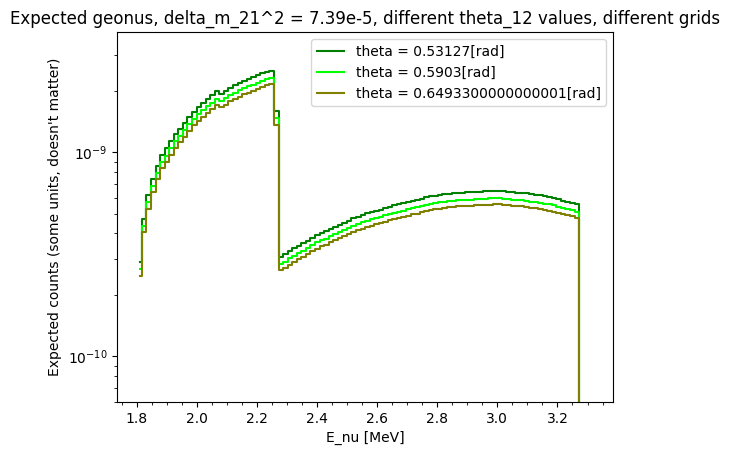

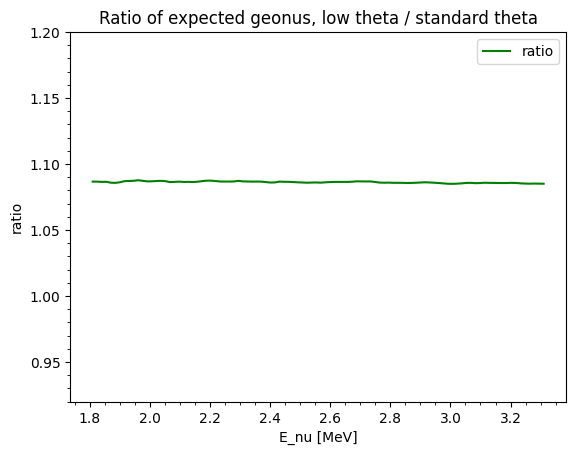

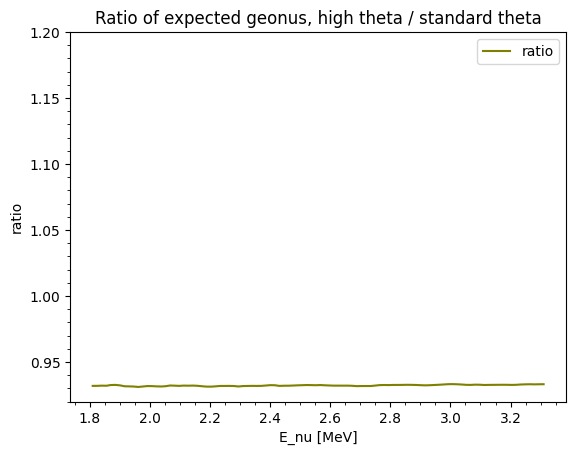

plots saved! yay!!


In [54]:

#plot comparisons
print("plot comparisons for different theta")
#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_theta_low_c + N_Th_theta_low_c + N_U_theta_low_m + N_Th_theta_low_m, where='mid', label=('theta = ' + str(theta_12_low) + '[rad]'), color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='theta = 0.5903[rad]', color='lime')
plt.step(energy_array, N_U_theta_high_c + N_Th_theta_high_c + N_U_theta_high_m + N_Th_theta_high_m, where='mid', label=('theta = ' + str(theta_12_high) + '[rad]'), color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, delta_m_21^2 = 7.39e-5, different theta_12 values, different grids')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard delta m fluxes
plt.savefig('Expected geonu, standard delta m, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_theta_low_c + N_Th_theta_low_c + N_U_theta_low_m + N_Th_theta_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, low theta / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
# standard delta m, low theta
plt.savefig('Ratio of expected geonu, standard delta m, low theta, Detailed Mantle.pdf', format='pdf')

plt.show()

plt.plot(energy_array, (N_U_theta_high_c + N_Th_theta_high_c + N_U_theta_high_m + N_Th_theta_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, high theta / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard delta m, high theta
plt.savefig('Ratio of expected geonu, standard delta m, high theta, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved! yay!!")

In [55]:
print("moving on to different delta_m_21^2 for standard theta ... ")

print("computing contribution for low delta_m^2 (crust only)")
Th_integral_values_delta_m_low_c, U_integral_values_delta_m_low_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12, delta_m_21_squared_low, A_Th_c, A_U_c, rho_c)

print("done!! moving on ... ")

moving on to different delta_m_21^2 for standard theta ... 
computing contribution for low delta_m^2 (crust only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2061.75 MB
deleted
Current memory usage: 2061.75 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 3087.73 MB
deleted
Current memory usage: 3087.73 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2061.83 MB
deleted
Current memory usage: 933.38 MB
done!! moving on ... 


In [56]:
print("computing contribution for low delta_m^2 (CLM only)")
Th_integral_values_delta_m_low_CLM, U_integral_values_delta_m_low_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_CLM, A_U_CLM, rho_CLM)

computing contribution for low delta_m^2 (CLM only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2788.61 MB
deleted
Current memory usage: 2788.61 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 4572.66 MB
deleted
Current memory usage: 4572.66 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2788.70 MB
deleted
Current memory usage: 933.39 MB


In [57]:
print("computing contribution for low delta_m^2 (DM only)")
Th_integral_values_delta_m_low_DM1, U_integral_values_delta_m_low_DM1 = integral_over_positions_Th_U(DM_grids[0], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM2, U_integral_values_delta_m_low_DM2 = integral_over_positions_Th_U(DM_grids[1], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM3, U_integral_values_delta_m_low_DM3 = integral_over_positions_Th_U(DM_grids[2], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM4, U_integral_values_delta_m_low_DM4 = integral_over_positions_Th_U(DM_grids[3], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM5, U_integral_values_delta_m_low_DM5 = integral_over_positions_Th_U(DM_grids[4], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM6, U_integral_values_delta_m_low_DM6 = integral_over_positions_Th_U(DM_grids[5], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM7, U_integral_values_delta_m_low_DM7 = integral_over_positions_Th_U(DM_grids[6], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM8, U_integral_values_delta_m_low_DM8 = integral_over_positions_Th_U(DM_grids[7], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM9, U_integral_values_delta_m_low_DM9 = integral_over_positions_Th_U(DM_grids[8], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM10, U_integral_values_delta_m_low_DM10 = integral_over_positions_Th_U(DM_grids[9], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM11, U_integral_values_delta_m_low_DM11 = integral_over_positions_Th_U(DM_grids[10], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM12, U_integral_values_delta_m_low_DM12 = integral_over_positions_Th_U(DM_grids[11], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM13, U_integral_values_delta_m_low_DM13 = integral_over_positions_Th_U(DM_grids[12], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM14, U_integral_values_delta_m_low_DM14 = integral_over_positions_Th_U(DM_grids[13], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM15, U_integral_values_delta_m_low_DM15 = integral_over_positions_Th_U(DM_grids[14], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM16, U_integral_values_delta_m_low_DM16 = integral_over_positions_Th_U(DM_grids[15], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM17, U_integral_values_delta_m_low_DM17 = integral_over_positions_Th_U(DM_grids[16], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM18, U_integral_values_delta_m_low_DM18 = integral_over_positions_Th_U(DM_grids[17], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM19, U_integral_values_delta_m_low_DM19 = integral_over_positions_Th_U(DM_grids[18], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_low, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_low_DM = Th_integral_values_delta_m_low_DM1 + Th_integral_values_delta_m_low_DM2 + Th_integral_values_delta_m_low_DM3 + Th_integral_values_delta_m_low_DM4 + Th_integral_values_delta_m_low_DM5 + Th_integral_values_delta_m_low_DM6 + Th_integral_values_delta_m_low_DM7 + Th_integral_values_delta_m_low_DM8 + Th_integral_values_delta_m_low_DM9 + Th_integral_values_delta_m_low_DM10 + Th_integral_values_delta_m_low_DM11 + Th_integral_values_delta_m_low_DM12 + Th_integral_values_delta_m_low_DM13 + Th_integral_values_delta_m_low_DM14 + Th_integral_values_delta_m_low_DM15 + Th_integral_values_delta_m_low_DM16 + Th_integral_values_delta_m_low_DM17 + Th_integral_values_delta_m_low_DM18 + Th_integral_values_delta_m_low_DM19

U_integral_values_delta_m_low_DM = U_integral_values_delta_m_low_DM1 + U_integral_values_delta_m_low_DM2 + U_integral_values_delta_m_low_DM3 + U_integral_values_delta_m_low_DM4 + U_integral_values_delta_m_low_DM5 + U_integral_values_delta_m_low_DM6 + U_integral_values_delta_m_low_DM7 + U_integral_values_delta_m_low_DM8 + U_integral_values_delta_m_low_DM9 + U_integral_values_delta_m_low_DM10 + U_integral_values_delta_m_low_DM11 + U_integral_values_delta_m_low_DM12 + U_integral_values_delta_m_low_DM13 + U_integral_values_delta_m_low_DM14 + U_integral_values_delta_m_low_DM15 + U_integral_values_delta_m_low_DM16 + U_integral_values_delta_m_low_DM17 + U_integral_values_delta_m_low_DM18 + U_integral_values_delta_m_low_DM19


computing contribution for low delta_m^2 (DM only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1500.75 MB
deleted
Current memory usage: 1500.75 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2021.66 MB
deleted
Current memory usage: 2021.66 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1500.75 MB
deleted
Current memory usage: 979.83 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed success

In [58]:
print("computing contribution for low delta_m^2 (EM only)")
Th_integral_values_delta_m_low_EM1, U_integral_values_delta_m_low_EM1 = integral_over_positions_Th_U(EM_grids[0],
                                                                                                     energy_array,
                                                                                                     grid_1d_size_mantle,
                                                                                                     theta_12,
                                                                                                     delta_m_21_squared_low,
                                                                                                     A_Th_EM, A_U_EM,
                                                                                                     rho_EM)

Th_integral_values_delta_m_low_EM2, U_integral_values_delta_m_low_EM2 = integral_over_positions_Th_U(EM_grids[1],
                                                                                                     energy_array,
                                                                                                     grid_1d_size_mantle,
                                                                                                     theta_12,
                                                                                                     delta_m_21_squared_low,
                                                                                                     A_Th_EM, A_U_EM,
                                                                                                     rho_EM)

Th_integral_values_delta_m_low_EM3, U_integral_values_delta_m_low_EM3 = integral_over_positions_Th_U(EM_grids[2],
                                                                                                     energy_array,
                                                                                                     grid_1d_size_mantle,
                                                                                                     theta_12,
                                                                                                     delta_m_21_squared_low,
                                                                                                     A_Th_EM, A_U_EM,
                                                                                                     rho_EM)

Th_integral_values_delta_m_low_EM4, U_integral_values_delta_m_low_EM4 = integral_over_positions_Th_U(EM_grids[3],
                                                                                                     energy_array,
                                                                                                     grid_1d_size_mantle,
                                                                                                     theta_12,
                                                                                                     delta_m_21_squared_low,
                                                                                                     A_Th_EM, A_U_EM,
                                                                                                     rho_EM)

Th_integral_values_delta_m_low_EM5, U_integral_values_delta_m_low_EM5 = integral_over_positions_Th_U(EM_grids[4],
                                                                                                     energy_array,
                                                                                                     grid_1d_size_mantle,
                                                                                                     theta_12,
                                                                                                     delta_m_21_squared_low,
                                                                                                     A_Th_EM, A_U_EM,
                                                                                                     rho_EM)

Th_integral_values_delta_m_low_EM6, U_integral_values_delta_m_low_EM6 = integral_over_positions_Th_U(EM_grids[5],
                                                                                                     energy_array,
                                                                                                     grid_1d_size_mantle,
                                                                                                     theta_12,
                                                                                                     delta_m_21_squared_low,
                                                                                                     A_Th_EM, A_U_EM,
                                                                                                     rho_EM)

Th_integral_values_delta_m_low_EM7, U_integral_values_delta_m_low_EM7 = integral_over_positions_Th_U(EM_grids[6],
                                                                                                     energy_array,
                                                                                                     grid_1d_size_mantle,
                                                                                                     theta_12,
                                                                                                     delta_m_21_squared_low,
                                                                                                     A_Th_EM, A_U_EM,
                                                                                                     rho_EM)

Th_integral_values_delta_m_low_EM = Th_integral_values_delta_m_low_EM1 + Th_integral_values_delta_m_low_EM2 + Th_integral_values_delta_m_low_EM3 + Th_integral_values_delta_m_low_EM4 + Th_integral_values_delta_m_low_EM5 + Th_integral_values_delta_m_low_EM6 + Th_integral_values_delta_m_low_EM7

U_integral_values_delta_m_low_EM = U_integral_values_delta_m_low_EM1 + U_integral_values_delta_m_low_EM2 + U_integral_values_delta_m_low_EM3 + U_integral_values_delta_m_low_EM4 + U_integral_values_delta_m_low_EM5 + U_integral_values_delta_m_low_EM6 + U_integral_values_delta_m_low_EM7


computing contribution for low delta_m^2 (EM only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1418.81 MB
deleted
Current memory usage: 1418.81 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1861.37 MB
deleted
Current memory usage: 1861.37 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1418.81 MB
deleted
Current memory usage: 976.21 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed success

In [59]:
Th_integral_values_delta_m_low_m = Th_integral_values_delta_m_low_CLM + Th_integral_values_delta_m_low_DM + Th_integral_values_delta_m_low_EM
U_integral_values_delta_m_low_m = U_integral_values_delta_m_low_CLM + U_integral_values_delta_m_low_DM + U_integral_values_delta_m_low_EM

In [60]:
print("computing contribution for high delta_m^2 (crust only)")
Th_integral_values_delta_m_high_c, U_integral_values_delta_m_high_c = integral_over_positions_Th_U(crust_grid, energy_array, grid_1d_size_crust, theta_12, delta_m_21_squared_high, A_Th_c, A_U_c, rho_c)

print("done!! moving on ... ")

computing contribution for high delta_m^2 (crust only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2061.89 MB
deleted
Current memory usage: 2061.89 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 3087.96 MB
deleted
Current memory usage: 3087.96 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2061.87 MB
deleted
Current memory usage: 933.42 MB
done!! moving on ... 


In [61]:
print("computing contribution for high delta_m^2 (CLM only)")
Th_integral_values_delta_m_high_CLM, U_integral_values_delta_m_high_CLM = integral_over_positions_Th_U(CLM_grid, energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_CLM, A_U_CLM, rho_CLM)

computing contribution for high delta_m^2 (CLM only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2788.65 MB
deleted
Current memory usage: 2788.65 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 4572.69 MB
deleted
Current memory usage: 4572.69 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 2788.96 MB
deleted
Current memory usage: 933.66 MB


In [62]:
print("computing contribution for high delta_m^2 (DM only)")
Th_integral_values_delta_m_high_DM1, U_integral_values_delta_m_high_DM1 = integral_over_positions_Th_U(DM_grids[0], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM2, U_integral_values_delta_m_high_DM2 = integral_over_positions_Th_U(DM_grids[1], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM3, U_integral_values_delta_m_high_DM3 = integral_over_positions_Th_U(DM_grids[2], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM4, U_integral_values_delta_m_high_DM4 = integral_over_positions_Th_U(DM_grids[3], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM5, U_integral_values_delta_m_high_DM5 = integral_over_positions_Th_U(DM_grids[4], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM6, U_integral_values_delta_m_high_DM6 = integral_over_positions_Th_U(DM_grids[5], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM7, U_integral_values_delta_m_high_DM7 = integral_over_positions_Th_U(DM_grids[6], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM8, U_integral_values_delta_m_high_DM8 = integral_over_positions_Th_U(DM_grids[7], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM9, U_integral_values_delta_m_high_DM9 = integral_over_positions_Th_U(DM_grids[8], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM10, U_integral_values_delta_m_high_DM10 = integral_over_positions_Th_U(DM_grids[9], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM11, U_integral_values_delta_m_high_DM11 = integral_over_positions_Th_U(DM_grids[10], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM12, U_integral_values_delta_m_high_DM12 = integral_over_positions_Th_U(DM_grids[11], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM13, U_integral_values_delta_m_high_DM13 = integral_over_positions_Th_U(DM_grids[12], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM14, U_integral_values_delta_m_high_DM14 = integral_over_positions_Th_U(DM_grids[13], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM15, U_integral_values_delta_m_high_DM15 = integral_over_positions_Th_U(DM_grids[14], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM16, U_integral_values_delta_m_high_DM16 = integral_over_positions_Th_U(DM_grids[15], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM17, U_integral_values_delta_m_high_DM17 = integral_over_positions_Th_U(DM_grids[16], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM18, U_integral_values_delta_m_high_DM18 = integral_over_positions_Th_U(DM_grids[17], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM19, U_integral_values_delta_m_high_DM19 = integral_over_positions_Th_U(DM_grids[18], energy_array, grid_1d_size_mantle, theta_12, delta_m_21_squared_high, A_Th_DM, A_U_DM, rho_DM)

Th_integral_values_delta_m_high_DM = Th_integral_values_delta_m_high_DM1 + Th_integral_values_delta_m_high_DM2 + Th_integral_values_delta_m_high_DM3 + Th_integral_values_delta_m_high_DM4 + Th_integral_values_delta_m_high_DM5 + Th_integral_values_delta_m_high_DM6 + Th_integral_values_delta_m_high_DM7 + Th_integral_values_delta_m_high_DM8 + Th_integral_values_delta_m_high_DM9 + Th_integral_values_delta_m_high_DM10 + Th_integral_values_delta_m_high_DM11 + Th_integral_values_delta_m_high_DM12 + Th_integral_values_delta_m_high_DM13 + Th_integral_values_delta_m_high_DM14 + Th_integral_values_delta_m_high_DM15 + Th_integral_values_delta_m_high_DM16 + Th_integral_values_delta_m_high_DM17 + Th_integral_values_delta_m_high_DM18 + Th_integral_values_delta_m_high_DM19

U_integral_values_delta_m_high_DM = U_integral_values_delta_m_high_DM1 + U_integral_values_delta_m_high_DM2 + U_integral_values_delta_m_high_DM3 + U_integral_values_delta_m_high_DM4 + U_integral_values_delta_m_high_DM5 + U_integral_values_delta_m_high_DM6 + U_integral_values_delta_m_high_DM7 + U_integral_values_delta_m_high_DM8 + U_integral_values_delta_m_high_DM9 + U_integral_values_delta_m_high_DM10 + U_integral_values_delta_m_high_DM11 + U_integral_values_delta_m_high_DM12 + U_integral_values_delta_m_high_DM13 + U_integral_values_delta_m_high_DM14 + U_integral_values_delta_m_high_DM15 + U_integral_values_delta_m_high_DM16 + U_integral_values_delta_m_high_DM17 + U_integral_values_delta_m_high_DM18 + U_integral_values_delta_m_high_DM19


computing contribution for high delta_m^2 (DM only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1501.16 MB
deleted
Current memory usage: 1501.16 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 2022.07 MB
deleted
Current memory usage: 2022.07 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1500.87 MB
deleted
Current memory usage: 979.95 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed succes

In [63]:
print("computing contribution for high delta_m^2 (EM only)")
Th_integral_values_delta_m_high_EM1, U_integral_values_delta_m_high_EM1 = integral_over_positions_Th_U(EM_grids[0],
                                                                                                       energy_array,
                                                                                                       grid_1d_size_mantle,
                                                                                                       theta_12,
                                                                                                       delta_m_21_squared_high,
                                                                                                       A_Th_EM, A_U_EM,
                                                                                                       rho_EM)

Th_integral_values_delta_m_high_EM2, U_integral_values_delta_m_high_EM2 = integral_over_positions_Th_U(EM_grids[1],
                                                                                                       energy_array,
                                                                                                       grid_1d_size_mantle,
                                                                                                       theta_12,
                                                                                                       delta_m_21_squared_high,
                                                                                                       A_Th_EM, A_U_EM,
                                                                                                       rho_EM)

Th_integral_values_delta_m_high_EM3, U_integral_values_delta_m_high_EM3 = integral_over_positions_Th_U(EM_grids[2],
                                                                                                       energy_array,
                                                                                                       grid_1d_size_mantle,
                                                                                                       theta_12,
                                                                                                       delta_m_21_squared_high,
                                                                                                       A_Th_EM, A_U_EM,
                                                                                                       rho_EM)

Th_integral_values_delta_m_high_EM4, U_integral_values_delta_m_high_EM4 = integral_over_positions_Th_U(EM_grids[3],
                                                                                                       energy_array,
                                                                                                       grid_1d_size_mantle,
                                                                                                       theta_12,
                                                                                                       delta_m_21_squared_high,
                                                                                                       A_Th_EM, A_U_EM,
                                                                                                       rho_EM)

Th_integral_values_delta_m_high_EM5, U_integral_values_delta_m_high_EM5 = integral_over_positions_Th_U(EM_grids[4],
                                                                                                       energy_array,
                                                                                                       grid_1d_size_mantle,
                                                                                                       theta_12,
                                                                                                       delta_m_21_squared_high,
                                                                                                       A_Th_EM, A_U_EM,
                                                                                                       rho_EM)

Th_integral_values_delta_m_high_EM6, U_integral_values_delta_m_high_EM6 = integral_over_positions_Th_U(EM_grids[5],
                                                                                                       energy_array,
                                                                                                       grid_1d_size_mantle,
                                                                                                       theta_12,
                                                                                                       delta_m_21_squared_high,
                                                                                                       A_Th_EM, A_U_EM,
                                                                                                       rho_EM)

Th_integral_values_delta_m_high_EM7, U_integral_values_delta_m_high_EM7 = integral_over_positions_Th_U(EM_grids[6],
                                                                                                       energy_array,
                                                                                                       grid_1d_size_mantle,
                                                                                                       theta_12,
                                                                                                       delta_m_21_squared_high,
                                                                                                       A_Th_EM, A_U_EM,
                                                                                                       rho_EM)

Th_integral_values_delta_m_high_EM = Th_integral_values_delta_m_high_EM1 + Th_integral_values_delta_m_high_EM2 + Th_integral_values_delta_m_high_EM3 + Th_integral_values_delta_m_high_EM4 + Th_integral_values_delta_m_high_EM5 + Th_integral_values_delta_m_high_EM6 + Th_integral_values_delta_m_high_EM7

U_integral_values_delta_m_high_EM = U_integral_values_delta_m_high_EM1 + U_integral_values_delta_m_high_EM2 + U_integral_values_delta_m_high_EM3 + U_integral_values_delta_m_high_EM4 + U_integral_values_delta_m_high_EM5 + U_integral_values_delta_m_high_EM6 + U_integral_values_delta_m_high_EM7


computing contribution for high delta_m^2 (EM only)
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1419.06 MB
deleted
Current memory usage: 1419.06 MB
Delta_31 computed successfully
   
Computed relative distances from Earth grid points to SNO+
   
computed; deleting useless stuff
Current memory usage: 1861.66 MB
deleted
Current memory usage: 1861.66 MB
Delta_12 computed successfully
values computed successfully
P_ee computed successfully
P_ee_array computed successfully
sum_Th computed successfully
sum_U computed successfully
computed; deleting useless stuff
Current memory usage: 1419.10 MB
deleted
Current memory usage: 976.50 MB
   
Computed relative distances from Earth grid points to SNO+
   
Relative distance array computed succes

In [64]:
Th_integral_values_delta_m_high_m = Th_integral_values_delta_m_high_CLM + Th_integral_values_delta_m_high_DM + Th_integral_values_delta_m_high_EM
U_integral_values_delta_m_high_m = U_integral_values_delta_m_high_CLM + U_integral_values_delta_m_high_DM + U_integral_values_delta_m_high_EM

print("total contribution done")

total contribution done


In [65]:
print("computing fluxes at detector location, low delta m^2")
N_Th_delta_m_low_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_low_c
N_U_delta_m_low_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_low_c

N_Th_delta_m_low_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_low_m
N_U_delta_m_low_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_low_m


computing fluxes at detector location, low delta m^2


In [66]:
print("computing fluxes at detector location, high delta m^2")
N_Th_delta_m_high_c = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_high_c
N_U_delta_m_high_c = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_high_c

N_Th_delta_m_high_m = ((lambda_Th)/(mu_Th)) * sigma * dn_dE_rebinned_Th * Th_integral_values_delta_m_high_m
N_U_delta_m_high_m = ((lambda_U)/(mu_U)) * sigma * dn_dE_rebinned_U * U_integral_values_delta_m_high_m


computing fluxes at detector location, high delta m^2


almost done! now making comparison plots ... 


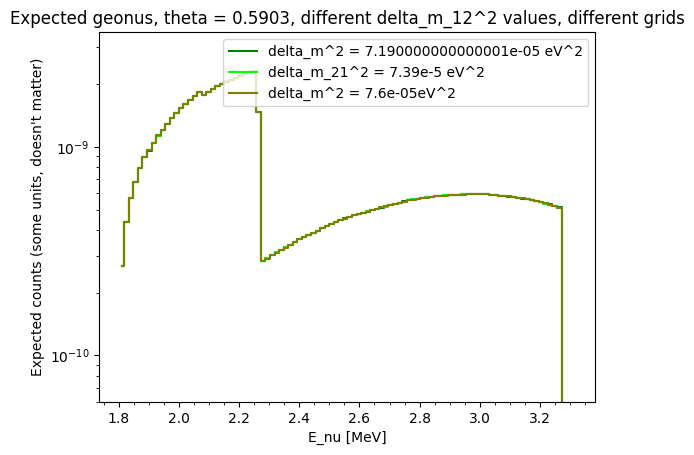

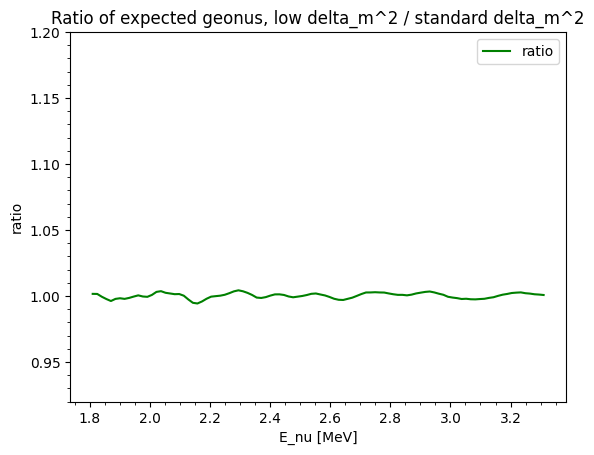

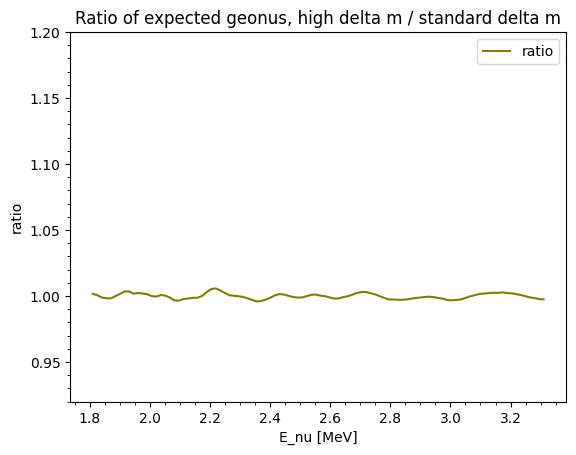

plots saved
   
All done! Congratulations!


In [67]:
print("almost done! now making comparison plots ... ")
#plot comparisons

#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_delta_m_low_c + N_Th_delta_m_low_c + N_U_delta_m_low_m + N_Th_delta_m_low_m, where='mid', label=('delta_m^2 = ' + str(delta_m_21_squared_low) + ' eV^2'), color='green')
plt.step(energy_array, N_U_c + N_Th_c + N_U_m + N_Th_m, where='mid', label='delta_m_21^2 = 7.39e-5 eV^2', color='lime')
plt.step(energy_array, N_U_delta_m_high_c + N_Th_delta_m_high_c + N_U_delta_m_high_m + N_Th_delta_m_high_m, where='mid', label=('delta_m^2 = ' + str(delta_m_21_squared_high) + 'eV^2'), color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, theta = 0.5903, different delta_m_12^2 values, different grids')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=6e-11)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard theta fluxes
plt.savefig('Expected geonu, standard theta, Detailed Mantle.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_delta_m_low_c + N_Th_delta_m_low_c + N_U_delta_m_low_m + N_Th_delta_m_low_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, low delta_m^2 / standard delta_m^2')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard theta, low delta m
plt.savefig('Ratio of expected geonu, standard theta, low delta m, Detailed Mantle.pdf', format='pdf')

plt.show()

plt.plot(energy_array, (N_U_delta_m_high_c + N_Th_delta_m_high_c + N_U_delta_m_high_m + N_Th_delta_m_high_m) / (N_U_c + N_Th_c + N_U_m + N_Th_m), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, high delta m / standard delta m')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)
# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=0.92, top=1.2)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
#FIG TO SAVE
#standard theta, high delta m
plt.savefig('Ratio of expected geonu, standard theta, high delta m, Detailed Mantle.pdf', format='pdf')

plt.show()

print("plots saved")

print("   ")

print("All done! Congratulations!")